Run the cell below if you are using Google Colab to mount your Google Drive in your Colab instance. Adjust the path to the files in your Google Drive as needed if it differs.

If you do not use Google Colab, running the cell will simply do nothing, so do not worry about it.

In [161]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab Notebooks/06_Clustering_Anomalies'
except ImportError as e:
    pass

# Cluster Analysis
- Find groups of objects that are similar to each other and different from others
- Goal: Understand the data
    - Exploration of the data
    - The “correct” cluster assigned is not known -> unsupervised learning
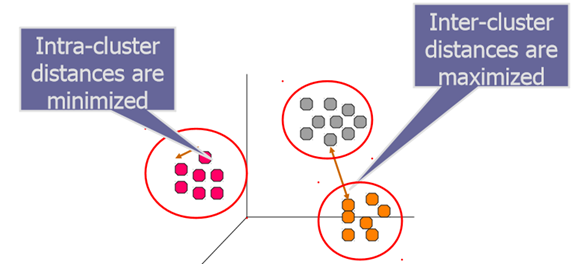

##  K-Means clustering:
- Partitional clustering approach
- Each example is assigned to its closest centroid
    - Requires a distance function!
- Number of clusters (k) must be specified manually
- Iteratively move the centroids to the centre of the clusters
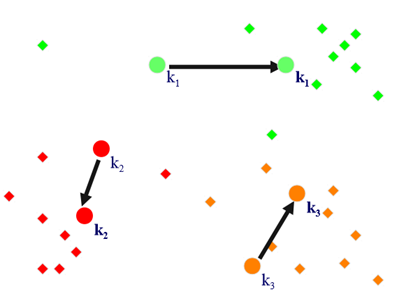


For visualization use https://www.naftaliharris.com/blog/visualizing-k-means-clustering/

ALGORITHM KMeans(data, k, max_iterations):
    // Initialize k centroids (randomly or using k-means++)
    centroids = SelectInitialCentroids(data, k)
    
    converged = false
    iter = 0
    
    WHILE NOT converged AND iter < max_iterations:
        // Assign each point to nearest centroid
        clusters = [[] for i = 1 to k]
        
        FOR point IN data:
            closest = argmin_j(Distance(point, centroids[j]))
            clusters[closest].append(point)
        
        // Store old centroids to check convergence
        old_centroids = centroids
        
        // Update centroids to cluster means
        FOR j = 0 to k-1:
            IF clusters[j] is not empty:
                centroids[j] = Mean(clusters[j])
        
        // Check for convergence
        converged = (centroids == old_centroids)
        iter++
    
    RETURN clusters, centroids

FUNCTION Distance(a, b):
    // Euclidean distance between points
    return √(∑(a_i - b_i)²)

FUNCTION Mean(points):
    // Calculate centroid as average of points
    return (∑points) / |points|

##  K-Means clustering:
- import [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from the sklearn.cluster package
- create an instance of the estimator using the KMeans() constructor
    - important parameters: ```n_clusters``` (the number of clusters)
    - this implementation always uses Euclidean distance!
- call the [```fit_predict()``` function](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_predict) to compute the clusters and return the cluster index for each example.
- call the [```fit``` function](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit) to compute the clusters. You can access the cluster indices for the examples using ```.labels_```

We will use the customer dataset of this exercise:

In [162]:
# import pandas
# !pip install xlrd
import pandas as pd

# load the dataset into a dataframe
customer_data = pd.read_excel('data\CustomerDataSet.xls')

# show the first few rows of the dataset
customer_data.head()

,Customer ID,ItemsBought,ItemsReturned,ZipCode,Product
0,4,45,10,2,1365
1,5,42,18,5,2764
2,6,50,0,1,1343
3,8,13,12,4,2435
4,9,10,7,3,2435


The dataset contains five attributes: a customer ID and zip code as well as the number of bought and returned items for different products.
For our analysis, we must first think about the meaning of these attributes and how we should use them.

The customer id identifies individual customers and is otherwise just a number with no meaning, so we will exclude it.
We might want to generate insights about our product portfolio and the performance in different regions, so we will use zip code and product for the interpretation of our results.
That leaves us with the two attributes items bought and items returned, which contain the factual data about our business.
It seems hence reasonable to use these two attributes for the clustering (also, using only two attributes allows us to plot everything in this exercise).

Before using the selected attributes, we normalise their values into the same range to make sure that each attribute has the same importance when calculating the distance between the records.

To solve the task, we do the following:
- Cluster on the attributes ```ItemsBought``` and ```ItemsReturned```
- Visualize (Scatter) the clustering using ```ItemsBought``` and ```ItemsReturned``` for the x and y-axes, and the cluster id for the color of the data points.
- repeat the clustering for different K values

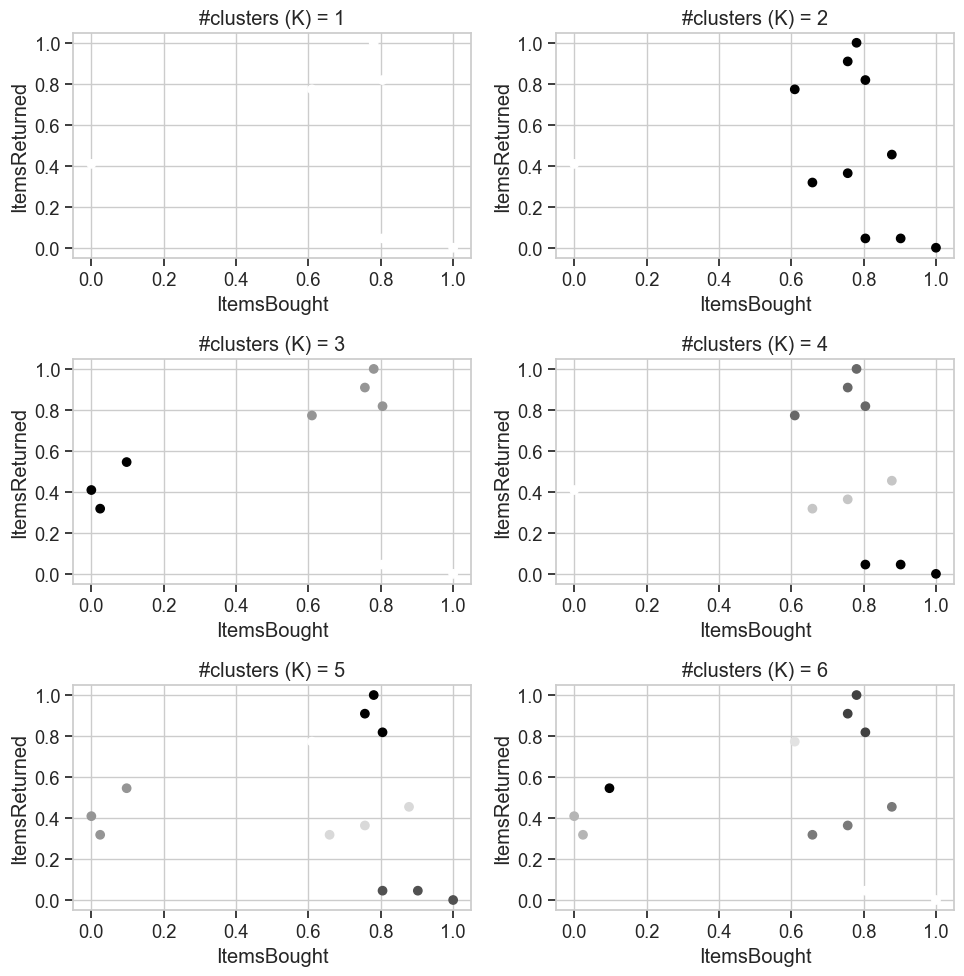

In [163]:
# import KMeans
from sklearn.cluster import KMeans

# import matplotlib
import matplotlib.pyplot as plt

# import preprocessing
from sklearn import preprocessing

# create the normaliser
scaler = preprocessing.MinMaxScaler()

# copy the dataframe before preprocessing so we can access the original values later
customer_copy = customer_data.copy()

# preprocess the features ItemsBought and ItemsReturned
customer_data[['ItemsBought', 'ItemsReturned']] = scaler.fit_transform(customer_data[['ItemsBought', 'ItemsReturned']])

# setup a figure
plt.figure(figsize=(10,10))

# iterate over all values that we want to test for K
for i in range(1,7):
    # create the clusterer
    estimator = KMeans(n_clusters = i)
    
    # create the clustering
    cluster_ids = estimator.fit_predict(customer_data[['ItemsBought', 'ItemsReturned']])

    # add a subplot
    plt.subplot(3,2,i)
    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout() 
    
    # setup the labels of the subplot
    plt.title("#clusters (K) = {}".format(i))
    plt.xlabel('ItemsBought')
    plt.ylabel('ItemsReturned')
    
    # create the scatter plot
    plt.scatter(customer_data['ItemsBought'], customer_data['ItemsReturned'], c=cluster_ids)
        
plt.show()

By looking at the plot it is quite easy for a human to find clusters of data points. The K-Means algorithm found these clusters, too:

K=3 makes sense as there are 3 distinct groups:

- Customers that buy a lot and keep the products (Best customers)
- Customers that buy a lot but also return some products (OK customers)
- Customers that don’t buy a lot and also return most products (Likely bad customers)

Alternatively, K=4 is also reasonable, where the cluster of our best customers is split into two parts.

#### What does the clustering tell you concerning your product portfolio?
Run the clustering again with K=3. Add the product ids to the plot using the annotate() function and interpret the results.

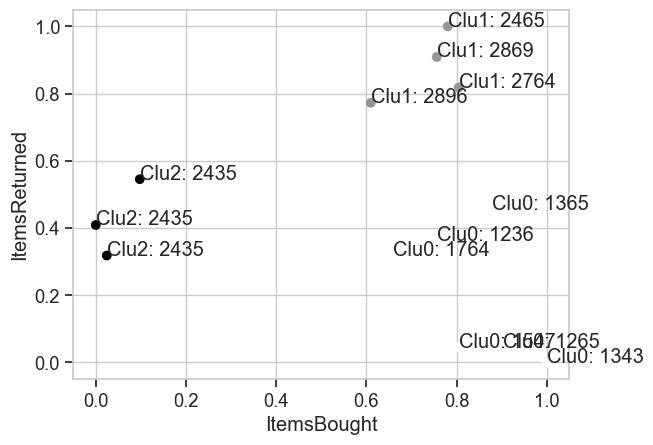

In [164]:
# create the clusterer for K = 3
estimator = KMeans(n_clusters = 3)

# create the clustering
cluster_ids = estimator.fit_predict(customer_data[['ItemsBought', 'ItemsReturned']])

# create a scatter plot
plt.scatter(customer_data['ItemsBought'], customer_data['ItemsReturned'], c=cluster_ids)

# annotate each data point with its product and cluster id
for index, c_id, bought, returned, zip_code, product in customer_data.itertuples():
    plt.annotate("Clu{}: {}".format(cluster_ids[index], product),(bought, returned))
    
# setup the labels of the plot
plt.xlabel('ItemsBought')
plt.ylabel('ItemsReturned')

# show the plot
plt.show()

We should stop selling product 2435, which is the only product in the bad cluster, as most customers return this product and don't keep it (likely because of bad product quality).
But the values in the plot are hard to understand because we normalised them.
For a better interpretation, let's look at the original values by selecting all records from the bad cluster and showing the data.

In [165]:
# select all records which have the cluster id of the bad cluster
# Note: you might have to change 2 to the according cluster id in your result
customer_copy[ cluster_ids == 1]

,Customer ID,ItemsBought,ItemsReturned,ZipCode,Product
1,5,42,18,5,2764
5,10,34,17,6,2896
6,11,40,20,8,2869
12,21,41,22,9,2465


#### What does the clustering tell you concerning your marketing efforts in different regions?

To answer this question, we simply plot again, but this time annotate the clusters with the zip code of the respective customers.
Note that we can use the original dataset instead of the preprocessed one for plotting and still use the clusters created on the preprocessed data, as both datasets have the same ordering of records.

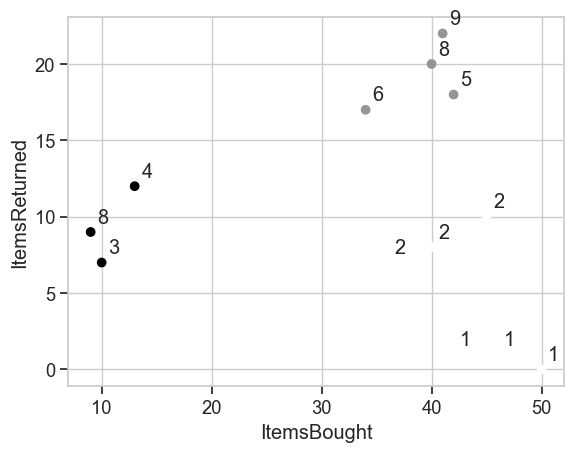

In [166]:
# create the scatter plot
plt.scatter(customer_copy['ItemsBought'], customer_copy['ItemsReturned'], c=cluster_ids)

# annotate each data point with the zip code value
for (index, c_id, bought, returned, zip_code, product) in customer_copy.itertuples():
    plt.annotate(zip_code,(bought + 0.6, returned + 0.6))
    
# setup the plot labels
plt.xlabel('ItemsBought')
plt.ylabel('ItemsReturned')

# show the plot
plt.show()

The plot shows that the best cluster contains only customers from regions with zip codes 1 and 2.
So we can assume that we're doing something right in these regions and should check if we can apply the same strategy in the other regions, too.

### Hierarchical Clustering
 
This method of clustering is particularly helpful if you want to have child clusters. For example, we could separate our customers into profitable customers and customers we lose money on. Likely we don't need to differentiate between customers that we lose money on, but we probably want to separate the other customers into high value customers and medium value customers or similar differentiations.

- Produces a set of nested clusters organised as tree
- two types are possible:
    - Agglomerative: "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged
    - Divisive: "top-down" approach: all observations start in one cluster, and splits are performed recursively
- if you are only interested in the clusters (no plotting), you can import [```AgglomerativeClustering```](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) from scikit-learn and use it in the same way as `KMeans`

- if you want to plot the dendrogams, use the [```linkage``` function](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html)  of the [```SciPy```](https://www.scipy.org/) package
    - ```linkage(data, method, metric)```
    - Performs agglomerative hierarchical clustering
    - second parameter specifies the linkage method (cluster similarity - see next slide)
    - metric parameter (the default "euclidean" is okay for us) can be one of "euclidean", "cityblock", "jaccard", "cosine" and others (see [```pdist``` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html))
- plotting is done with the [```dendrogram``` function](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html)
    - ```dendrogram(Z)``` where ```Z``` is the result of the linkage function
    - Use ```dendrogram(Z,labels=list(data['column']))``` to add labels to the plot
    - The plot will colour the dendrogram into potential clusters according to a heuristic, which can be adjusted using the ```color_threshold``` parameter

- cluster similarity:
    - "single" (Single Link/Min): use the shortest distance of any 2 examples in the two clusters
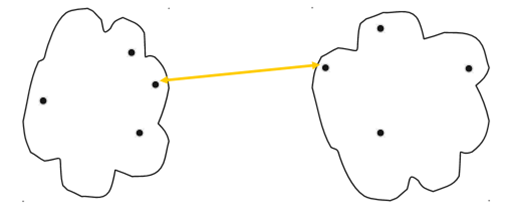
    - "complete" (Complete Link/Max): use longest distance between any 2 examples in two clusters
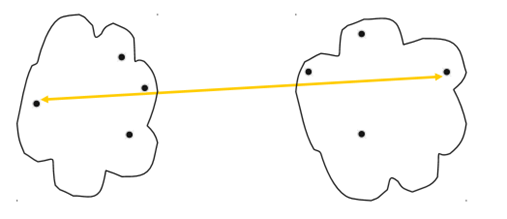
    - "average" (Group Average): use the average of all pair-wise distances for the clusters
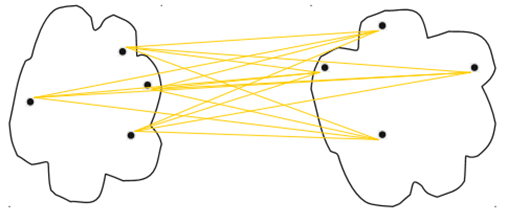

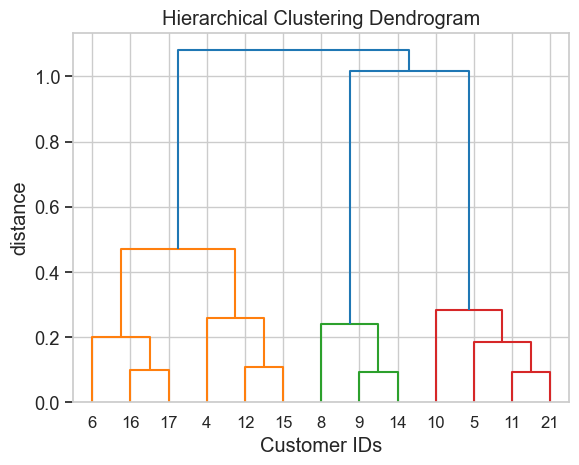

In [167]:
# import dendrogram and linkage from scipy
from scipy.cluster.hierarchy import dendrogram, linkage

# create the hierarchical clustering
Z = linkage(customer_data[['ItemsBought', 'ItemsReturned']], 'complete')

# set the plot title
plt.title('Hierarchical Clustering Dendrogram')

# set the axis labels
plt.xlabel('Customer IDs')
plt.ylabel('distance')

# plot the dendrogram
dendrogram(Z, labels=list(customer_data['Customer ID']))

# show the plot
plt.show()

##### Truncate the dendrogram
- The dendrogram can be hard to read when the dataset is large. Truncation is used to condense it. 
- setting ```truncate_mode``` to ```lastp```
- set the ```p``` attribute to the number of clusters (leaf nodes in the hierarchy) that you want to show

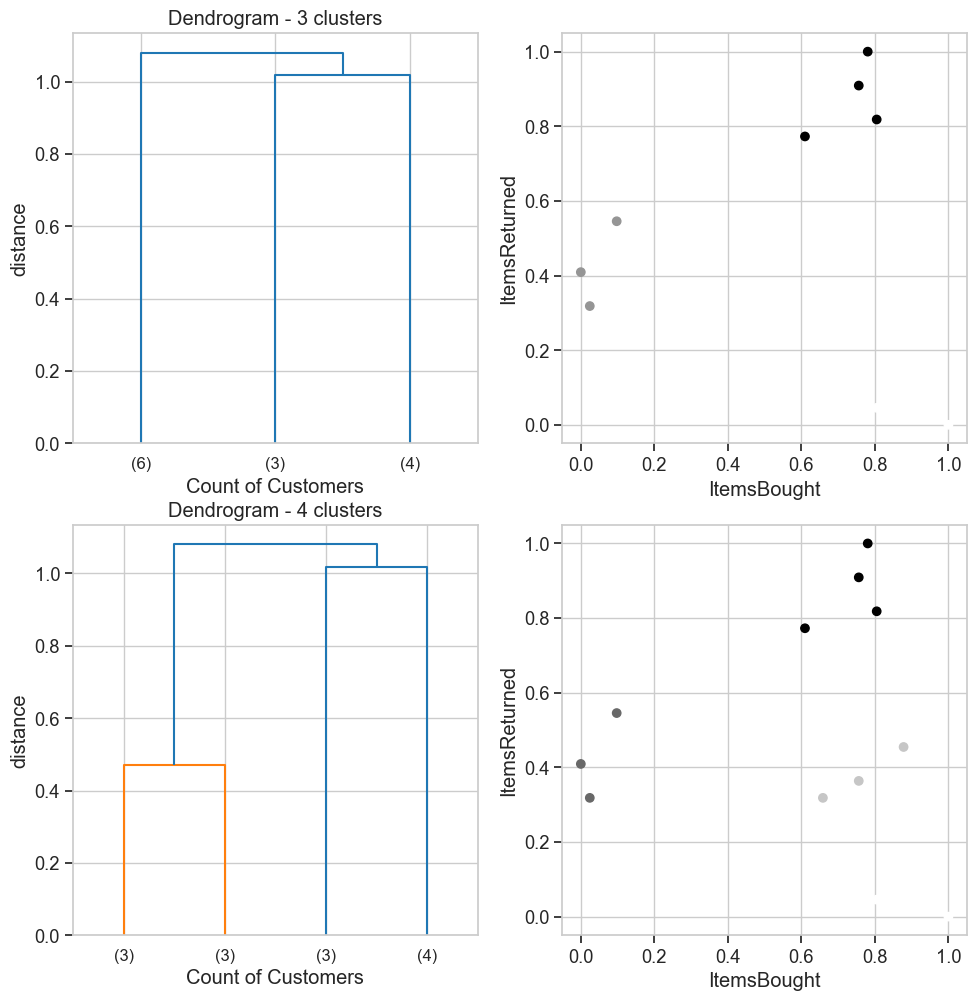

In [168]:
# import fcluster
from scipy.cluster.hierarchy import fcluster

# setup a figure
plt.figure(figsize=(10,10))

# iterate over the different numbers of clusters that we want to consider (here: 3 and 4)
counter = 1
for i in [3,4]:
    # add a sub plot
    plt.subplot(2,2,counter)
    counter += 1
    
    # setup the layout of the plot
    plt.tight_layout()
    plt.title('Dendrogram - {} clusters'.format(i))
    plt.xlabel('Count of Customers')
    plt.ylabel('distance')
    
    # plot the dendrogram
    dendrogram(Z, truncate_mode='lastp', p=i)
    
    # add a second sub plot
    plt.subplot(2,2,counter)
    counter += 1
    
    # create the clusters by cutting the hierarchy
    clusters = fcluster(Z, i, criterion='maxclust')
    
    # create a scatter plot coloured according to the clusteres
    plt.scatter(customer_data['ItemsBought'], customer_data['ItemsReturned'], c=clusters)
    
    # setup the plot labels
    plt.xlabel('ItemsBought')
    plt.ylabel('ItemsReturned')
    
# show the figure
plt.show()

Conclusion:
- 3 Groups: Same result as K-Means with K=3.
- 4 Groups: The cluster of the good customers is divided when using 4 clusters
    - Customers buying a lot and keeping (almost) everything (Best Customers)
    - Customers buying a lot and keeping most of the products (Good Customers)
    - Customers buying a lot but returning a significant number of products (Average Customers)
    - Customers returning almost all products (likely bad Customers)

 You can change the orientation of the dendrogram with the ```orientation``` parameter:

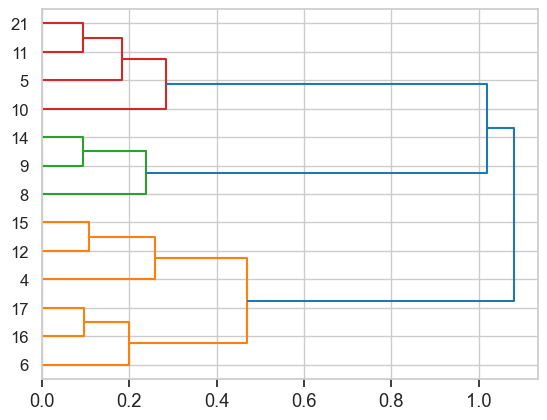

In [169]:
dendrogram(Z, orientation='right', labels=list(customer_data['Customer ID']))
plt.show()

### Agglomerative Hierarchical Clustering in scikit-learn
- like KMeans
- see Scikit Learn's documentation for [```AgglomerativeClustering```](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
    - ```n_clusters``` specifies the number of clusters (i.e., where to cut the hierarchy)
    - ```linkage``` specifies the linkage mode (single, complete, average)
    - ```affinity``` specifies the similarity/distance measure
- function [```fit_predict```](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering.fit_predict): Performs clustering on X and returns cluster labels.

In [1]:
# import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

# create the clusterer
agg = AgglomerativeClustering(n_clusters = 3, linkage='single')

# create the clusters
clusters = agg.fit_predict(customer_data[['ItemsBought', 'ItemsReturned']])

# create a scatter plot
plt.scatter(customer_data['ItemsBought'], customer_data['ItemsReturned'], c=clusters)

# show the plot
plt.show()

NameError: name 'customer_data' is not defined

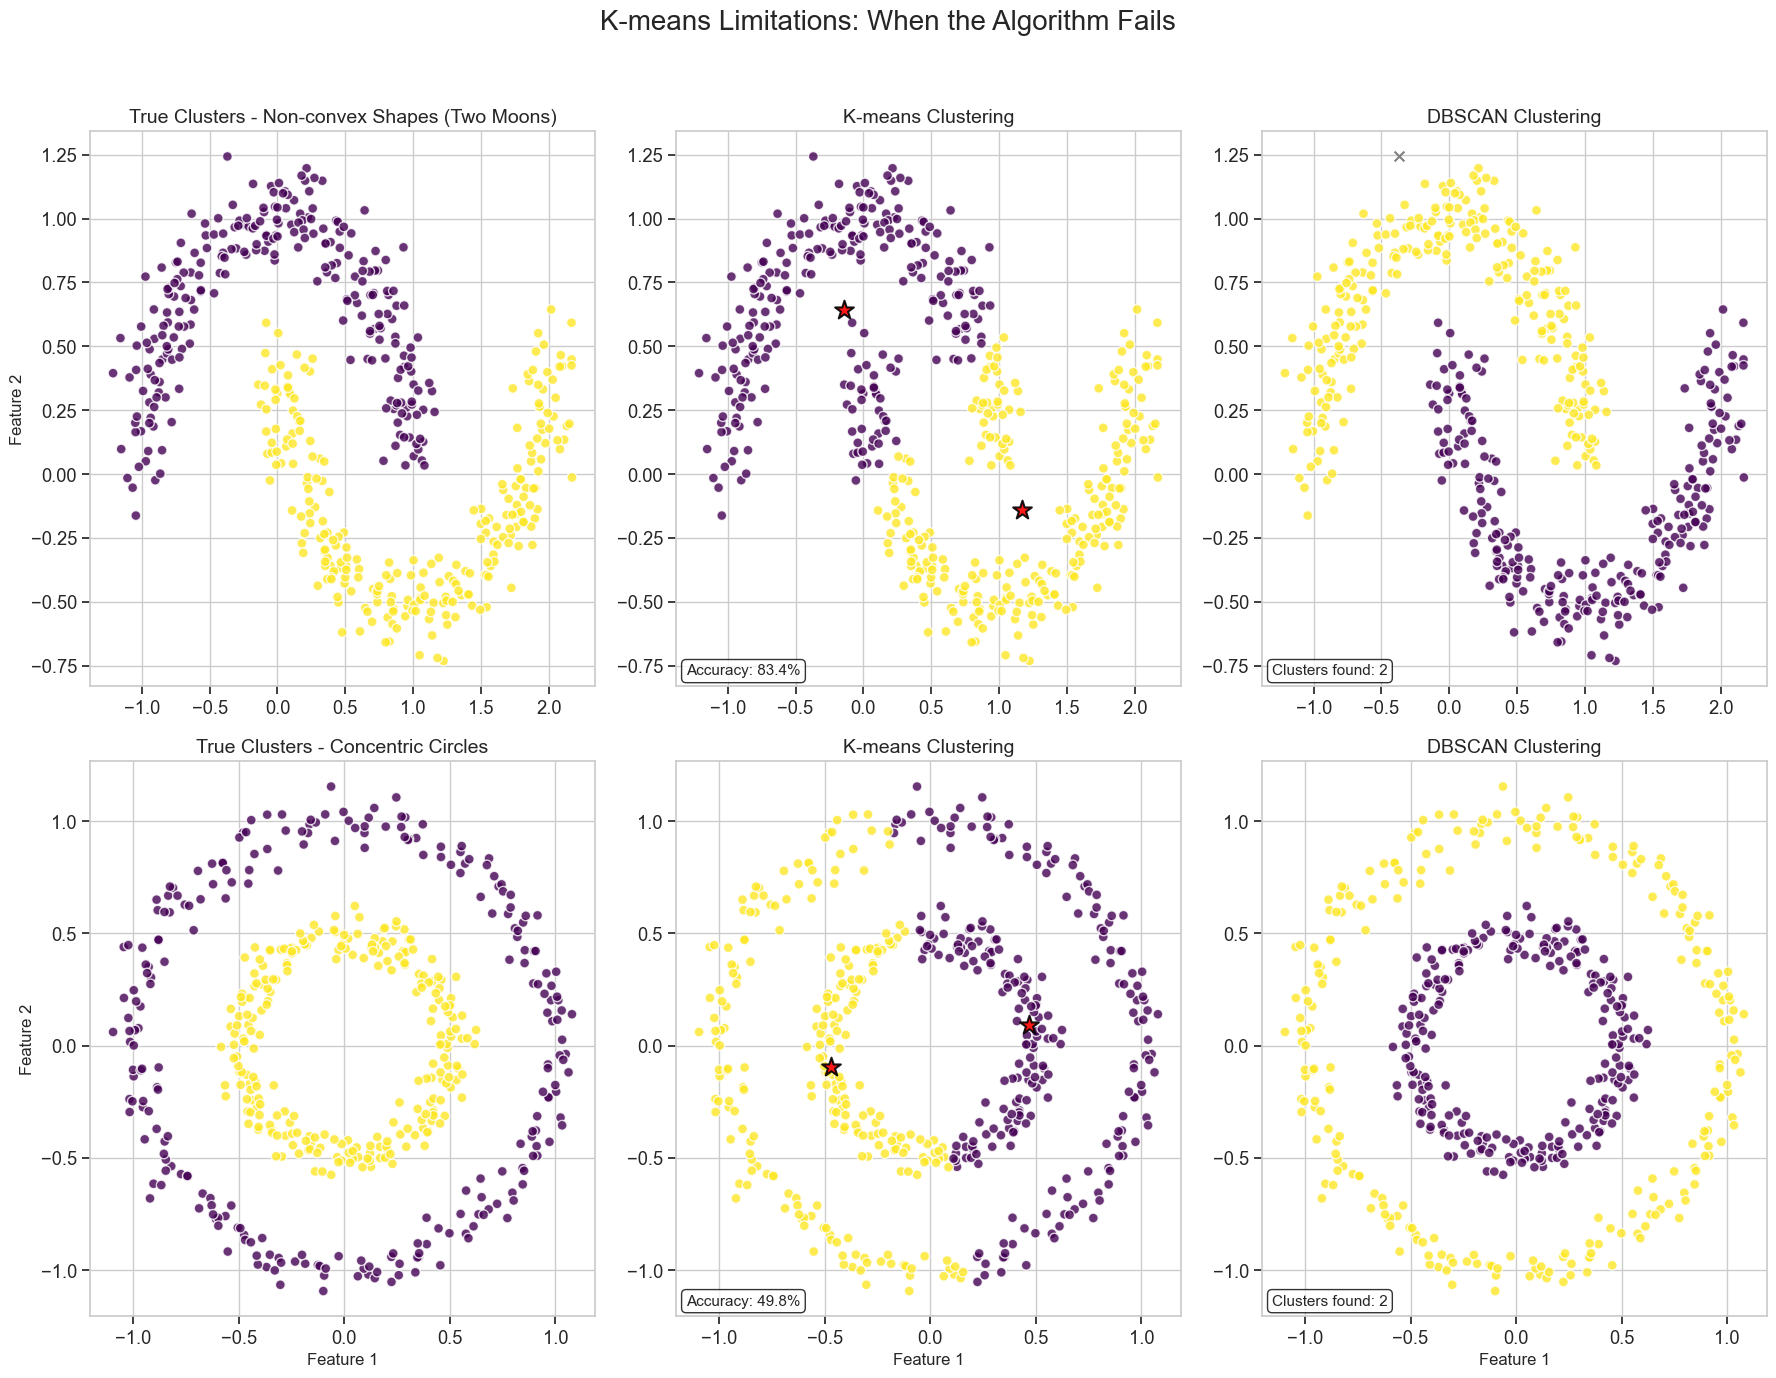

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

def generate_challenging_datasets():
    """Generate datasets that challenge K-means assumptions"""
    
    # Dataset 1: Two moons (non-convex shapes)
    X1, y1 = make_moons(n_samples=500, noise=0.1, random_state=42)
    
    # Dataset 2: Concentric circles (non-convex and non-separable by linear boundaries)
    X2, y2 = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)
    
    return [(X1, y1, "Non-convex Shapes (Two Moons)"), 
            (X2, y2, "Concentric Circles")]

def plot_clustering_comparison(datasets):
    """Plot datasets with true labels, K-means and DBSCAN clustering results"""
    
    fig = plt.figure(figsize=(18, 15))
    gs = GridSpec(len(datasets), 3, figure=fig)
    
    for i, (X, y_true, title) in enumerate(datasets):
        # Scale the data for better clustering
        X_scaled = StandardScaler().fit_transform(X)
        
        # True labels
        ax0 = fig.add_subplot(gs[i, 0])
        ax0.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', 
                    s=50, alpha=0.8, edgecolor='w')
        ax0.set_title(f"True Clusters - {title}", fontsize=14)
        if i == len(datasets) - 1:
            ax0.set_xlabel("Feature 1", fontsize=12)
        ax0.set_ylabel("Feature 2", fontsize=12)
        
        # K-means clustering (use the known number of clusters from true labels)
        n_clusters = len(np.unique(y_true))
        if -1 in np.unique(y_true):  # Adjust if outliers are labeled as -1
            n_clusters -= 1
            
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        y_kmeans = kmeans.fit_predict(X_scaled)
        
        ax1 = fig.add_subplot(gs[i, 1])
        ax1.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', 
                    s=50, alpha=0.8, edgecolor='w')
        
        # Plot centroids
        centers = kmeans.cluster_centers_
        centers = StandardScaler().fit(X).inverse_transform(centers)
        ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, 
                    marker='*', edgecolor='black', linewidth=1.5)
        
        # Calculate and display accuracy (percentage of points in correct clusters)
        # Note: This is a simplistic measure and doesn't account for label permutations
        # A more robust approach would use adjusted Rand index or other clustering metrics
        if -1 not in np.unique(y_true):  # Skip accuracy calculation if there are outliers
            accuracy = np.sum(np.abs(y_true - y_kmeans) == 0) / len(y_true) * 100
            acc_text = f"Accuracy: {accuracy:.1f}%"
        else:
            acc_text = "Accuracy: N/A (outliers present)"
            
        ax1.text(0.02, 0.02, acc_text, transform=ax1.transAxes, fontsize=11,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
        
        ax1.set_title("K-means Clustering", fontsize=14)
        if i == len(datasets) - 1:
            ax1.set_xlabel("Feature 1", fontsize=12)
        
        # DBSCAN clustering (params need tuning per dataset)
        if i == 0:  # Two moons
            eps, min_samples = 0.3, 5
        elif i == 1:  # Concentric circles
            eps, min_samples = 0.4, 5
        elif i == 2:  # Different density
            eps, min_samples = 0.3, 5
        elif i == 3:  # Anisotropic
            eps, min_samples = 0.5, 5
        else:  # Overlapping with outliers
            eps, min_samples = 0.6, 5
            
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        y_dbscan = dbscan.fit_predict(X_scaled)
        
        ax2 = fig.add_subplot(gs[i, 2])
        
        # Handle noise points in DBSCAN (-1 label)
        mask_noise = y_dbscan == -1
        mask_clustered = ~mask_noise
        
        # Plot clustered points
        ax2.scatter(X[mask_clustered, 0], X[mask_clustered, 1], 
                   c=y_dbscan[mask_clustered], cmap='viridis', 
                   s=50, alpha=0.8, edgecolor='w')
        
        # Plot noise points
        if np.any(mask_noise):
            ax2.scatter(X[mask_noise, 0], X[mask_noise, 1], 
                      c='gray', marker='x', s=50, label='Noise')
            
        # Number of clusters found by DBSCAN
        n_clusters_dbscan = len(np.unique(y_dbscan[y_dbscan >= 0]))
        ax2.text(0.02, 0.02, f"Clusters found: {n_clusters_dbscan}", 
                transform=ax2.transAxes, fontsize=11,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
        
        ax2.set_title("DBSCAN Clustering", fontsize=14)
        if i == len(datasets) - 1:
            ax2.set_xlabel("Feature 1", fontsize=12)
            
    # Add an overall title
    fig.suptitle("K-means Limitations: When the Algorithm Fails", fontsize=20, y=0.98)
    
    plt.tight_layout(rect=[0, 0.06, 1, 0.96])
    return fig

# Main function to run the demonstration
def demonstrate_kmeans_limitations():
    # Generate datasets that challenge K-means
    challenging_datasets = generate_challenging_datasets()
    
    # Create and display the comparison visualization
    fig = plot_clustering_comparison(challenging_datasets)
    plt.show()
    return fig

# Run the demonstration
if __name__ == "__main__":
    demonstrate_kmeans_limitations()

As we can see, K-means clustering makes some fundamental assumptions in its modeling. If these assumptions do not hold, we end up with undesirable outcomes. Therefore, instead of relying on distance to cluster points together, we can use density-based approaches to achieve better results if the distribution breaks the assumptions of K-means.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise):
- Examples separated into Core, Border and Noise Points
- Can handle clusters of different shapes and sizes
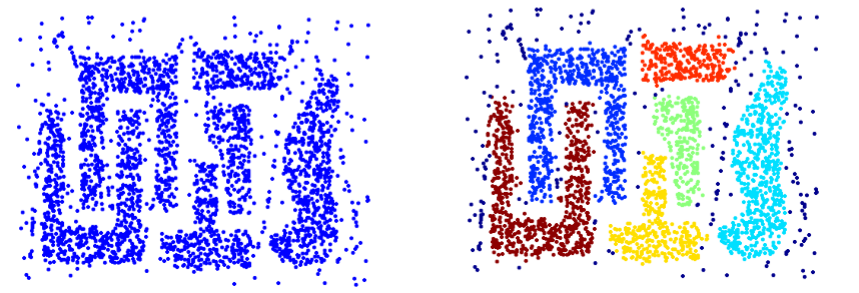
- See documentation for [```DBSCAN```](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
- important parameters are:
    - ```min_samples```: The minimum number of points in the neighbourhood for a point to be considered a core point
    - ```eps```: The maximum distance between two points to be considered neighbours
    - ```metric```: The distance function, for example ```'euclidean'```, ```'cosine'```, or ```'manhattan'```

For an interactive visualization of how DBSCAN works, visit:
https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

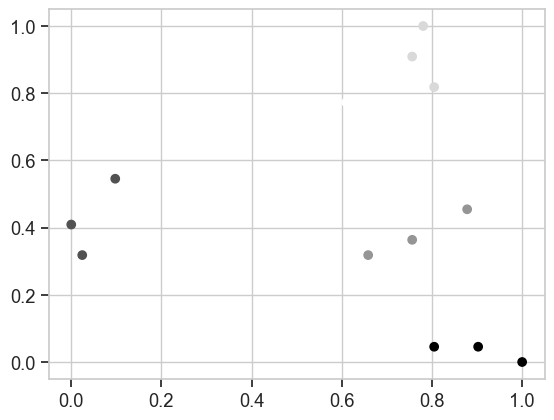

In [172]:
# import DBSCAN
from sklearn.cluster import DBSCAN

# create the clusterer
clusterer = DBSCAN(min_samples=3, eps=0.2, metric='euclidean')

# create the clusters
clusters = clusterer.fit(customer_data[['ItemsBought', 'ItemsReturned']])

# create a scatter plot
plt.scatter(customer_data['ItemsBought'], customer_data['ItemsReturned'], c=clusters.labels_)

# show the plot
plt.show()

# Anomaly Detection

## Motivation

Anomaly detection is a critical task in data mining that helps identify unusual patterns that don't conform to expected behavior. These outliers are often indicative of:

- **Data quality issues** that require cleaning
- **Fraud or security breaches** requiring immediate attention
- **Rare but important events** such as equipment failures
- **Novel findings** that could lead to new discoveries

While sophisticated algorithms exist, simple statistical methods like the Interquartile Range (IQR) provide robust detection with minimal assumptions about data distribution. The IQR method is particularly valuable because:

- It's resistant to extreme values, unlike mean-based approaches
- It works well for skewed distributions where standard deviation fails
- It requires no training data or complex parameter tuning
- It's computationally efficient for large datasets

## Impact of IQR Multiplier Selection

| IQR Multiplier | % Observations Flagged as Outliers* | Typical Application |
|----------------|-------------------------------------|---------------------|
| 1.0 | ~4.5% | Very sensitive detection, preliminary data cleaning |
| 1.5 | ~0.7% | Standard detection, general purpose analysis (Tukey's rule) |
| 2.0 | ~0.1% | Conservative detection, reducing false positives |
| 2.5 | ~0.01% | Very conservative, only extreme outliers |
| 3.0 | ~0.0002% | Extremely conservative, critical systems where false alarms are costly |

*Percentages assume normally distributed data. For heavy-tailed distributions (like financial returns), the percentage of outliers will be significantly higher.

## Distribution Effects
- **Normal distribution**: The percentages above apply
- **Uniform distribution**: Fewer outliers than predicted by the table
- **Heavy-tailed distributions** (e.g., stock returns): Many more outliers than predicted
- **Skewed distributions**: Asymmetric outlier detection (more outliers on one side)

## Interquartile Range

Definitions:
- Q1: $x \geq Q1$ holds for 75% of all x = median of the lower half
- Q3: $x \geq Q3$ holds for 25% of all x = median of the upper half
- $IQR = Q3 - Q1$

Outlier detection:
- All values outside $[Q1  - 1.5* IQR; Q3 + 1.5*IQR]$

Example: find outliers in \[3, 5, 6, 6, 8, 11, 21\] with IQR

- Q1 = median of \[3, 5, 6\]: 5
- Q3 = median of \[8, 11, 21\]: 11
- IQR = 11-5 = 6
- Allowed interval: \[5 - 1.5 * 6, 11 + 1.5 * 6\] = \[-4, 20\]
- Outlier: 21

The factor 1.5 is not arbitrary—it identifies approximately 0.7% of observations as outliers in normally distributed data while remaining effective for non-normal distributions. For more conservative detection, some domains use a factor of 3.0, which marks only the most extreme values as outliers.

### P&P (1): Find outliers with Interquartile Range

- Find outliers in [-5, 3, 7, 11] 
- Find outliers in [-14, -12, 7, 10, 11, 12, 14, 16.5, 17, 38] 

# Outlier Detection Using the IQR Method

**Dataset:** `[-5, 3, 7, 11]`

# Explanation of Q1 Calculation

For the dataset `[-5, 3, 7, 11]`:

- The sorted dataset is: `[-5, 3, 7, 11]`
- Since there are 4 numbers, the lower half is `[-5, 3]`
- **Q1** is the median of the lower half, calculated as:

  \[
  Q1 = \frac{-5 + 3}{2} = -1
  \]

Thus, Q1 is `-1`.


- **Q1 (First Quartile):** -1  
- **Q3 (Third Quartile):** 9  
- **IQR:** `Q3 - Q1 = 10`

**Allowed Interval:**  
- Lower Bound: `Q1 - 1.5 * IQR = -1 - 15 = -16`  
- Upper Bound: `Q3 + 1.5 * IQR = 9 + 15 = 24`

**Conclusion:**  
All values lie within `[-16, 24]`, so there are **no outliers**.


Find outliers in  \[-14, -12, 7, 10, 11, 12, 14, 16.5, 17, 38\] 

- Q1 = 7 
- Q3 = 16.5 
- IQR = 9.5
- Allowed interval: \[-7.25, 30.75\] 
- Conclusion: -14, -12, and 38 are outliers

## Median Absolute Deviation (MAD)

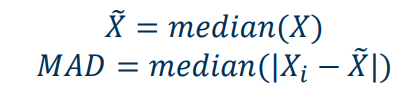

- all values that are k*MAD away from the median are considered to be outliers

E.g., k = 3

Find outliers in \[3, 5, 6, 6, 8, 11, 21\] with MAD

- Median: 6
- Deviations: \[3, 1, 0, 0, 2, 5, 15\]
- Sorted deviations: \[0, 0, 1, 2, 3, 5, 15\]
- MAD: 2
- Allowed Interval=[Median−k×MAD,Median+k×MAD]
- Allowed interval: \[6 - 3 * 2, 6 + 3 * 2\] = \[0, 12\]
- Outliers: 21

### P&P (2): Find outliers with MAD; use k=3

- Find outliers in [-5, 3, 7, 11] 
- Find outliers in [-14, -12, 7, 10, 11, 12, 14, 16.5, 17, 38] 

#### Solution 

Find outliers in \[-5, 3, 7, 11\] 

- Median: 5
- Deviations: \[10, 2, 2, 6\]
- Sorted deviations: \[2, 2, 6, 10\]
- MAD = 4
- Allowed interval: \[-7, 17\] 
- Conclusion: no outliers

# Outlier Detection Using MAD

**Dataset:** `[-5, 3, 7, 11]`

1. **Median Calculation:**
   - Sorted data: `[-5, 3, 7, 11]`
   - Median = (3 + 7) / 2 = **5**

2. **Absolute Deviations:**
   - Calculate the deviations from the median (5):
     - | -5 - 5 | = 10  
     - | 3 - 5 | = 2  
     - | 7 - 5 | = 2  
     - | 11 - 5 | = 6  
   - Deviations: `[10, 2, 2, 6]`
   - Sorted deviations: `[2, 2, 6, 10]`

3. **MAD Calculation:**
   - With an even number of deviations, MAD is the average of the two middle values:
   - MAD = (2 + 6) / 2 = **4**

4. **Allowed Interval (with k = 3):**
   - Lower Bound: 5 - 3×4 = **-7**
   - Upper Bound: 5 + 3×4 = **17**
   - Allowed Interval: `[-7, 17]`

5. **Conclusion:**
   - All values lie within the interval `[-7, 17]`, so there are **no outliers**.


Find outliers in  \[-14, -12, 7, 10, 11, 12, 14, 16.5, 17, 38\] 

- Median: 11.5
- Deviations: \[25.5, 23.5, 4.5, 1.5, 0.5, 0.5, 2.5, 5, 5.5, 26.5\]
- Sorted deviations: \[0.5, 0.5, 1.5, 2.5, 4.5, 5, 5.5, 23.5, 25.5, 26.5\]
- MAD = 4.75
- Allowed interval: \[-2.75, 25.75\] 
- Conclusion: -14, -12, and 38 are outliers

# Outlier Detection: How LOF and Isolation Forest Work

## Local Outlier Factor (LOF)

LOF is a density-based method that identifies outliers by comparing the local density of a point to the densities of its neighbors.

**How LOF Works:**

1. **Find k-nearest neighbors** for each data point (controlled by the `n_neighbors` parameter)

2. **Calculate local density** for each point based on how far it is from its neighbors
   - For normal points in dense regions, this distance is small
   - For outliers, this distance is larger

3. **Compare densities** by calculating a ratio:
   ```
   LOF Score = Average density of neighbors / Density of the point
   ```

4. **Identify outliers:** Points with significantly higher LOF scores are outliers because their local density is much lower than their neighbors

**Visual intuition:** LOF is great at finding points that are suspiciously far from their local neighborhood, even when those points wouldn't be global outliers.

## Isolation Forest

Isolation Forest takes a completely different approach based on the principle that outliers are "few and different," making them easier to isolate.

**How Isolation Forest Works:**

1. **Build random trees** that partition the data:
   - Randomly select a feature
   - Randomly select a split value between min and max
   - Repeat until points are isolated

2. **Measure isolation depth** - how many splits it takes to isolate each point:
   - Outliers typically need fewer splits (they're "easier" to isolate)
   - Normal points typically need more splits

3. **Average across many trees** to get reliable anomaly scores

4. **Set threshold** based on the expected contamination rate (percentage of outliers)

**Visual intuition:** Imagine playing a game of "20 Questions" to identify someone. Outliers are like celebrities - they're identified in fewer questions because they have unusual characteristics!

## When to Use Each

- **Use LOF when:** Your data has varying densities or complex shapes, and outliers are defined relative to their local neighborhood
- **Use Isolation Forest when:** You have high-dimensional data, many data points, or want a more efficient algorithm with fewer assumptions about data distribution

Both techniques are far more sophisticated than simple statistical methods (like z-scores) because they can identify outliers in complex, multi-dimensional spaces rather than just looking at individual variables.


In this task we use an artifical data set with only two features to experiment with anomaly detection techniques. In addition to the "correct" data points that form clusters, there are 27 random data points. Use the techniques from scikit-learn to spot the outliers.
- Visualise and inspect the data. Can you already see the outliers?
- We will use the LocalOutlierFactor and IsolationForest techniques to spot outliers

In [173]:
# use the following command to run the notebook without any warnings:
import warnings
warnings.filterwarnings(action='ignore')

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('artificial.txt', sep='\t').drop(columns='ID')

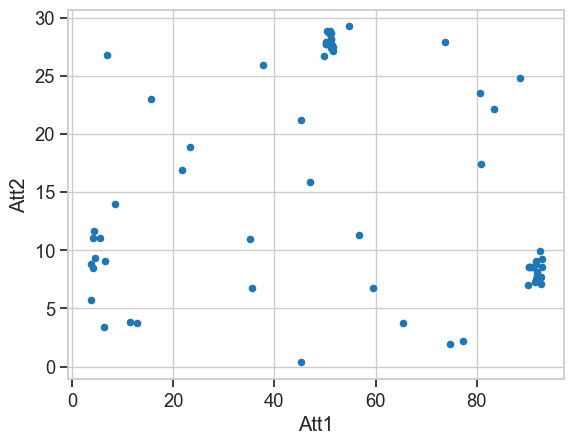

In [175]:
df.plot.scatter(x='Att1', y='Att2')
plt.show()

--- BASIC ESTIMATORS ---


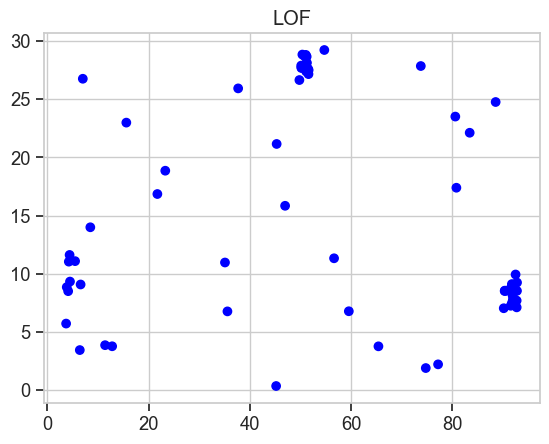

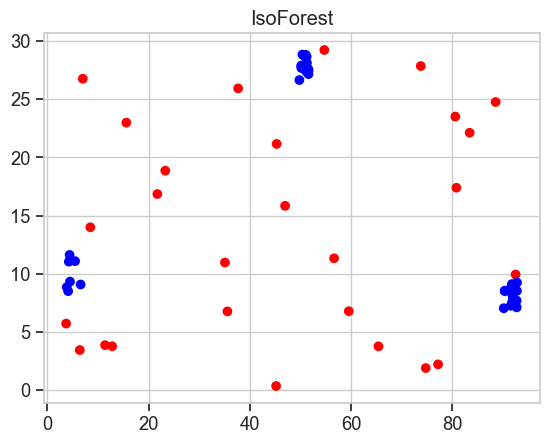


--- TUNED ESTIMATORS ---


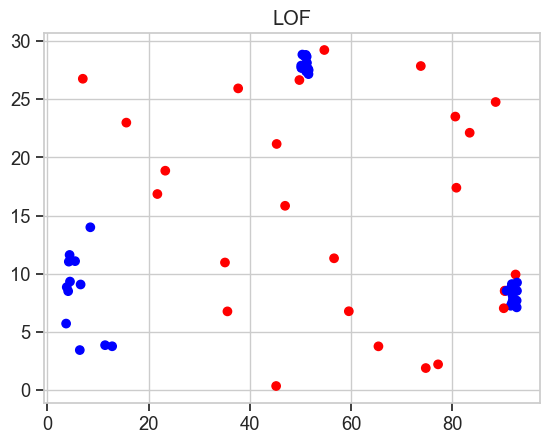

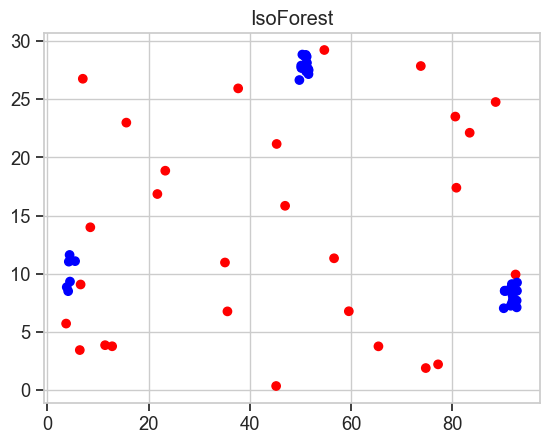

In [176]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

estimators = {'LOF': LocalOutlierFactor(), 'IsoForest': IsolationForest()}
estimators_tuned = {
    'LOF': LocalOutlierFactor(n_neighbors=10, contamination=.4),
    'IsoForest': IsolationForest(contamination='auto')
}

def tag_outliers(df, estimator):
    return df.assign(status=np.array(['inlier' if x == 1 else 'outlier' for x in estimator.fit_predict(df)]))

def visualise_outliers(df, e, e_name):
    df = tag_outliers(df, e)
    plt.scatter(x=df['Att1'], y=df['Att2'], c=['Blue' if s == 'inlier' else 'Red' for s in df['status']])
    plt.title(e_name)
    plt.show()

print('--- BASIC ESTIMATORS ---')
for e_name, e in estimators.items():
    visualise_outliers(df, e, e_name)
    
print()
print('--- TUNED ESTIMATORS ---')
for e_name, e in estimators_tuned.items():
    visualise_outliers(df, e, e_name)
    

Conclusion: IsolationForest works best (at least for this artificial problem) and does not even need much tuning to perform well.

# More Exercises (Homework)

## P&P (3). $k$-means  by hand

The following 10 data points are given in a 2-dimensional space:
$D = \{a=(1,7), \; b=(2,7), \; c=(6,5), \; d=(3,2), \; e=(4,6), \; f=(3,4), \; g=(7,3), \; h=(1,2)\}$

The initial centroids are given as follows:
$$\{ \mu_1=(2,3), \; \mu_2=(4,7), \; \mu_3=(5,4) \} $$ 

A visualization of the data points and centroids is shown in the Figure below ( Ci​ =  μi​)

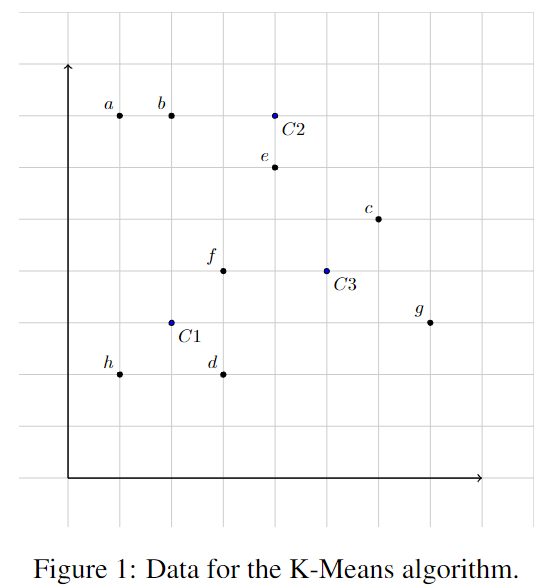


Your task is to carry out the $k$-Means clustering algorithm with $k=3$ on these data points. 
Use the **Euclidean distance** as a distance measure:

$$ distance(\mathbf{x},\mathbf{y}) = \sqrt{\sum_{i=1}^{n} \left( x_i - y_i\right)^{2}}$$

**⚠️ PERFORM ONLY ONE ITERATION OF THE ALGORITHM**:

1. Compute distances between every point in $D$ and each of the 3 centroids 
2. Assing every point in $D$ to its closest centroid
2. Compute the position of the new centroids


### Solution

1) Distance computation

|         |  a(1,7) |  b(2,7) |  c(6,5)  |  d(3,2)  |  e(4,6) |  f(3,4)  |  g(7,3)  |  h(1,2)  |
|:-------:|:-------:|:-------:|:--------:|:--------:|:-------:|:--------:|:--------:|:--------:|
| $\mu_1$ (2,3) |   4.12  |   4.0   |   4.47   | **1.41** |   3.61  | **1.41** |    5.0   | **1.41** |
| $\mu_2$ (4,7) | **3.0** | **2.0** |   2.83   |    5.1   | **1.0** |   3.16   |    5.0   |   5.83   |
| $\mu_3$ (5,4) |   5.0   |   4.24  | **1.41** |   2.83   |   2.24  |    2.0   | **2.24** |   4.47   |

2) Cluster formation: every point in $D$ is assigend to its closest centroid. You can simply read the bolded numbers of rows of the table above

$$ C_1 = \{d, f, h \} $$
$$ C_2 = \{a, b, e\} $$
$$ C_3 = \{c, g\} $$

3) New centroid computation

$$\mu_1' = \frac{(d+f+h)}{3} = (\frac{7}{3}, \frac{8}{3}) $$
$$\mu_2' = \frac{(a+b+e)}{3} = (\frac{7}{3}, \frac{20}{3})$$
$$\mu_3' = \frac{(c+g)}{2} = (\frac{13}{2}, 4)$$


---

## Step 1: Assign Points to the Closest Centroid

The Manhattan distance between two points (x₁, y₁) and (x₂, y₂) is given by:  
\[
d = |x₁ - x₂| + |y₁ - y₂|
\]

Calculate distances for each point:

- **a = (1,7):**
  - d(a, μ₁) = |1-2| + |7-3| = 1 + 4 = 5  
  - d(a, μ₂) = |1-4| + |7-7| = 3 + 0 = 3  
  - d(a, μ₃) = |1-5| + |7-4| = 4 + 3 = 7  
  → **Assign to μ₂**

- **b = (2,7):**
  - d(b, μ₁) = |2-2| + |7-3| = 0 + 4 = 4  
  - d(b, μ₂) = |2-4| + |7-7| = 2 + 0 = 2  
  - d(b, μ₃) = |2-5| + |7-4| = 3 + 3 = 6  
  → **Assign to μ₂**

- **c = (6,5):**
  - d(c, μ₁) = |6-2| + |5-3| = 4 + 2 = 6  
  - d(c, μ₂) = |6-4| + |5-7| = 2 + 2 = 4  
  - d(c, μ₃) = |6-5| + |5-4| = 1 + 1 = 2  
  → **Assign to μ₃**

- **d = (3,2):**
  - d(d, μ₁) = |3-2| + |2-3| = 1 + 1 = 2  
  - d(d, μ₂) = |3-4| + |2-7| = 1 + 5 = 6  
  - d(d, μ₃) = |3-5| + |2-4| = 2 + 2 = 4  
  → **Assign to μ₁**

- **e = (4,6):**
  - d(e, μ₁) = |4-2| + |6-3| = 2 + 3 = 5  
  - d(e, μ₂) = |4-4| + |6-7| = 0 + 1 = 1  
  - d(e, μ₃) = |4-5| + |6-4| = 1 + 2 = 3  
  → **Assign to μ₂**

- **f = (3,4):**
  - d(f, μ₁) = |3-2| + |4-3| = 1 + 1 = 2  
  - d(f, μ₂) = |3-4| + |4-7| = 1 + 3 = 4  
  - d(f, μ₃) = |3-5| + |4-4| = 2 + 0 = 2  
  → **Assign to μ₁** (tie-break: choose μ₁)

- **g = (7,3):**
  - d(g, μ₁) = |7-2| + |3-3| = 5 + 0 = 5  
  - d(g, μ₂) = |7-4| + |3-7| = 3 + 4 = 7  
  - d(g, μ₃) = |7-5| + |3-4| = 2 + 1 = 3  
  → **Assign to μ₃**

- **h = (1,2):**
  - d(h, μ₁) = |1-2| + |2-3| = 1 + 1 = 2  
  - d(h, μ₂) = |1-4| + |2-7| = 3 + 5 = 8  
  - d(h, μ₃) = |1-5| + |2-4| = 4 + 2 = 6  
  → **Assign to μ₁**

**Cluster Assignments:**

- **Cluster 1 (μ₁):** d = (3,2), f = (3,4), h = (1,2)
- **Cluster 2 (μ₂):** a = (1,7), b = (2,7), e = (4,6)
- **Cluster 3 (μ₃):** c = (6,5), g = (7,3)

---

## Step 2: Recalculate New Centroids Using Coordinate-wise Medians

For Manhattan distance, the best centroid is computed by taking the median of the coordinates in each dimension.

**Cluster 1:** Points: `(3,2)`, `(3,4)`, `(1,2)`
- **X-coordinates:** 3, 3, 1 → Sorted: 1, 3, 3 → Median = **3**
- **Y-coordinates:** 2, 4, 2 → Sorted: 2, 2, 4 → Median = **2**
- **New Centroid:** `(3,2)`

**Cluster 2:** Points: `(1,7)`, `(2,7)`, `(4,6)`
- **X-coordinates:** 1, 2, 4 → Sorted: 1, 2, 4 → Median = **2**
- **Y-coordinates:** 7, 7, 6 → Sorted: 6, 7, 7 → Median = **7**
- **New Centroid:** `(2,7)`

**Cluster 3:** Points: `(6,5)`, `(7,3)`
- **X-coordinates:** 6, 7 → Median = (6 + 7) / 2 = **6.5**  
  *(For an even number of points, any value between the two is optimal; here, we use the average.)*
- **Y-coordinates:** 5, 3 → Sorted: 3, 5 → Median = (3 + 5) / 2 = **4**
- **New Centroid:** `(6.5, 4)`

---

## Summary of New Centroids

- **New μ₁:** `(3,2)`
- **New μ₂:** `(2,7)`
- **New μ₃:** `(6.5, 4)`

This procedure shows that after assigning points based on Manhattan distances, the new centroids are recalculated by taking the median of the x- and y-coordinates of all points in each cluster.


## P&P (4): k-NN and Local Outlier Factor

1. Look up workings of k-NN and LOF*
2. Identify the top two outliers using k-NN approach with k=3. Use either the maximum or average distance
3. Compute the LOF outlier score for the two outliers identified in step 2 (with k=3). Which one is greater?

**Hint:** For convenience, use Manhattan distance as distance metric!
You can use “Simplified LOF” where the density of a point is 1/k-distance.


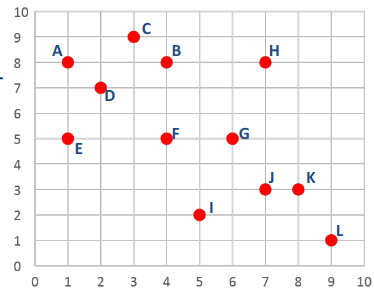

### Solution 4.2

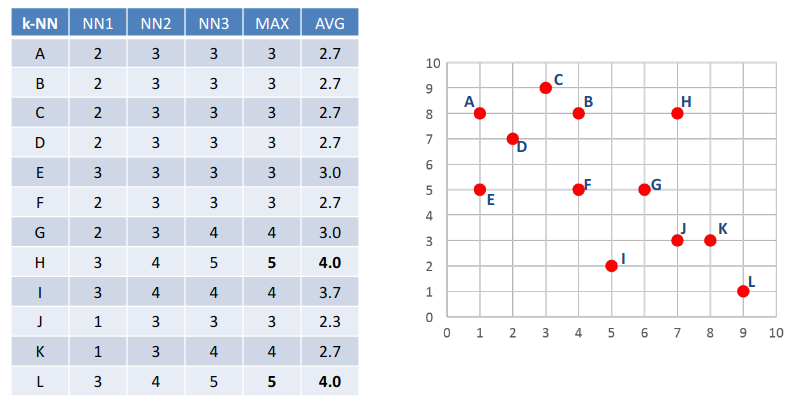

### Solution 4.3

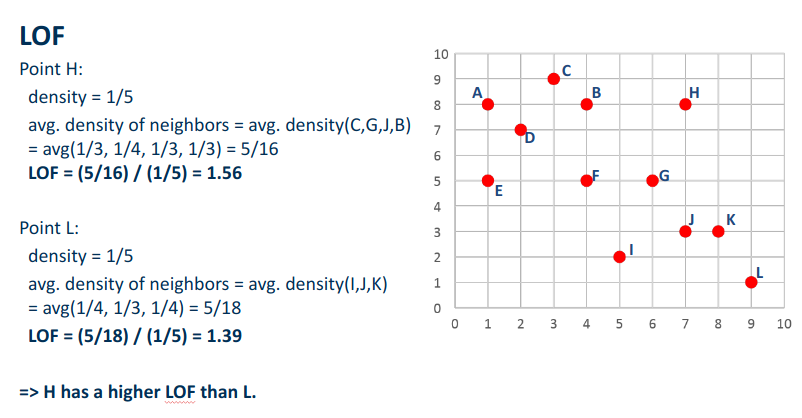

## P&P (5) Isolation Forests

Using Isolation Forests, you want to find outliers in the dataset below.

Compute the outlier score (i.e., the probability of the data point ending in a leaf of height 1) for every point in the dataset.

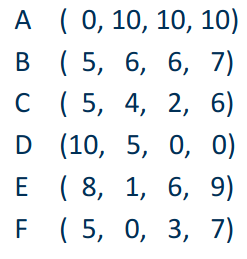


### Solution

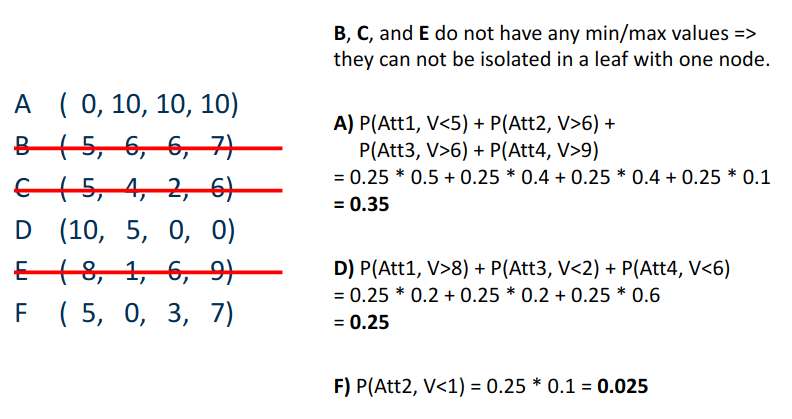

## H1. Clustering Students

### H1.1. Aggregate the students data set by student and calculate the average mark and the average number of attended classes

In [177]:
# load the excel file into a dataframe
student_data = pd.read_excel('data\Student Data for Exercise 1.xls')

# show the first few records
display(student_data.head())

# group the dataframe by student name and calculate the mean values
students = student_data.groupby('Name').mean(numeric_only=True)

# show the first few records
display(students.head())

,Semester,Name,Course,Mark,Attended
0,FSS2010,Alex Krausche,Database Systems I,1.3,13
1,FSS2010,Tanja Becker,Database Systems I,2.0,12
2,FSS2010,Mariano Selina,Database Systems I,1.7,5
3,FSS2010,Otto Blacher,Database Systems I,2.3,13
4,FSS2010,Frank Fester,Database Systems I,2.0,13


,Mark,Attended
Name,,
Alex Krausche,1.325,12.500000
Avid Morvita,3.100,11.333333
Frank Fester,2.200,11.600000
Mariano Selina,1.680,6.200000
Michaela Martke,3.660,7.400000


### H1.2 Cluster the data set using the K-Means algorithm. Does one attribute dominate the clustering? What can you do about this? Assign suitable labels to your clusters.

Run a K-Means clusterer on the data and plot it in a scatter plot. Its a good idea to annotate the data points with the names of the students.

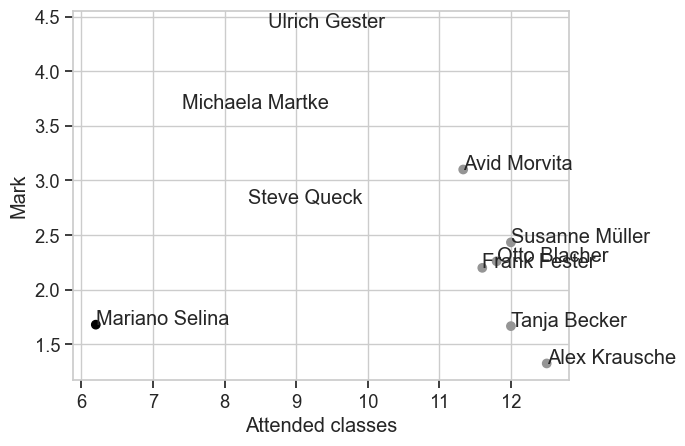

In [178]:
# create the clusterer
estimator = KMeans(n_clusters = 3)

# create the clustering
cluster_ids = estimator.fit_predict(students)

# create the scatter plot
plt.scatter(students['Attended'], students['Mark'], c=cluster_ids)

# setup the labels
plt.xlabel("Attended classes")
plt.ylabel("Mark")

# annotate each data point with the name of the student
for index, mark, attended in students.itertuples():
    plt.annotate(index, (attended, mark))
    
plt.show()

### Solution
- Clustering is dominated by the number of average attended classes
- Avoid by normalizing this value to the data range of marks [1..5] (or normalize both between 0..1)
- There are 3 different groups of students (K=3):
    - Students attending often and getting good marks (good students)
    - Students attending almost never and getting bad marks (likely bad students)
    - Students attending seldom and getting good marks (high-flyer)

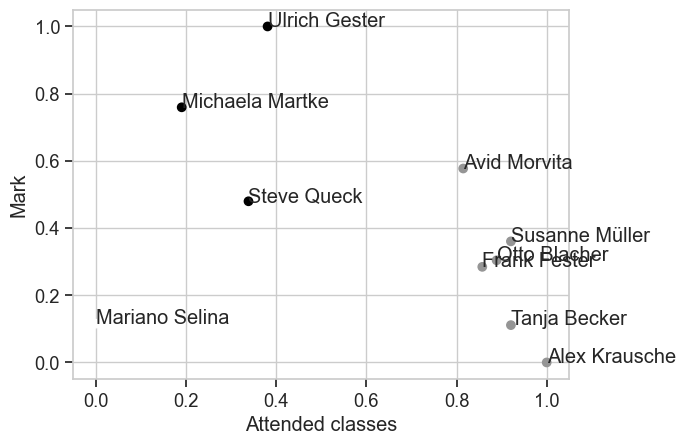

In [179]:
# create the normaliser
min_max_scaler = preprocessing.MinMaxScaler()

# normalise the features
students[['Mark', 'Attended']] = min_max_scaler.fit_transform(students[['Mark', 'Attended']])

# create the clusterer
estimator = KMeans(n_clusters = 3)

# create the clustering
cluster_ids = estimator.fit_predict(students)

# create the scatter plot
plt.scatter(students['Attended'], students['Mark'], c=cluster_ids)

# setup the labels
plt.xlabel("Attended classes")
plt.ylabel("Mark")

# annotate each data point with the name of the student
for index, mark, attended in students.itertuples():
    plt.annotate(index, (attended, mark))
    
plt.show()

### H1.3. Cluster the data set using Agglomerative Hierarchical Clustering. Experiment with different settings for calculating the cluster similarity. What is a good setting?

We first define which settings we want to test (the different linkage modes) and then iterate over these values in a for loop.
Inside the loop, we create the clustering with the respective settings and plot the dendrogram.

In this solution, we use a different approach to adding subplots to a figure:
We use the ```subplot``` function to add a new subplot, and assign the return value to a variable named ```y_axis```.
By passing this variable to all calls to ```subplot``` using the ```sharey``` parameter, we tell all plots to use the same y-axis.

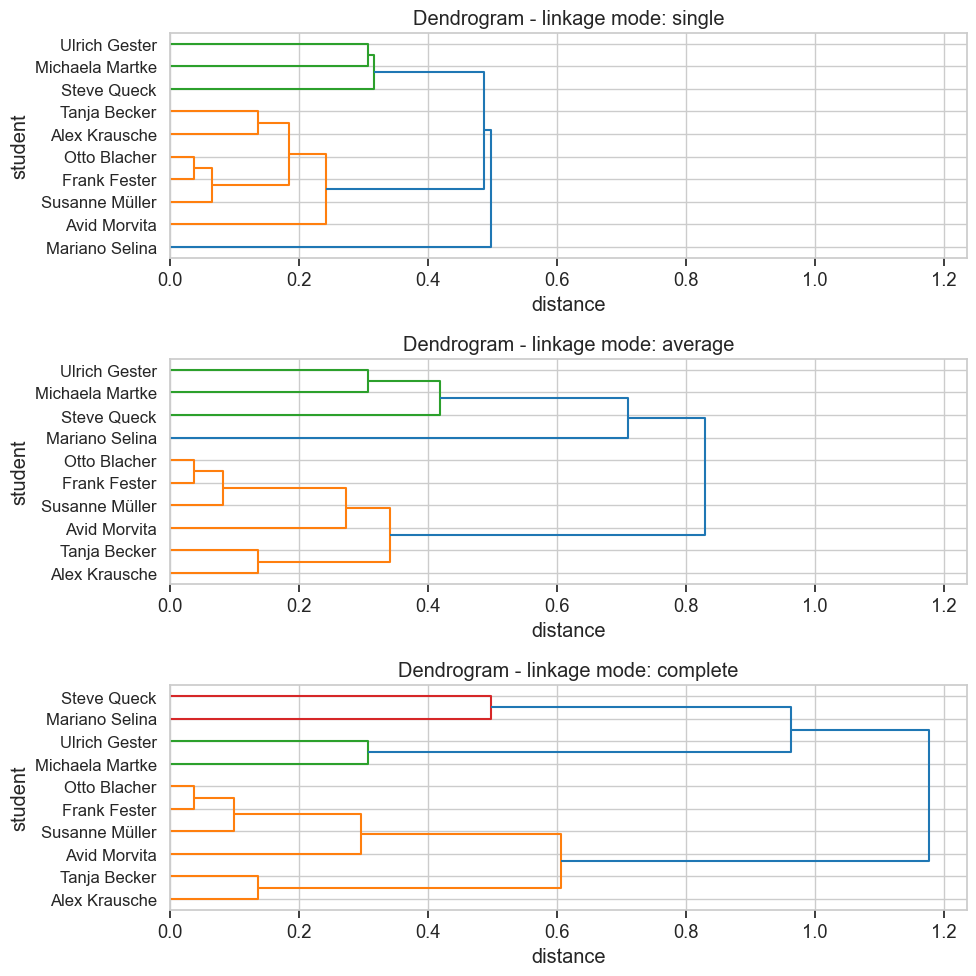

In [180]:
# define the different linkage modes that we want to test
modes = ['single', 'average', 'complete']

# create a figure
plt.figure(figsize=(10,10))

# create a variable for the shared x axis
x_axis = None

# iterate over all linkage modes
for i, mode in enumerate(modes):
    # add a subplot and pass the shared y axis
    x_axis = plt.subplot(3,1,i + 1, sharex = x_axis)
    
    # setup the labels
    plt.title('Dendrogram - linkage mode: {}'.format(mode))
    plt.xlabel('distance')
    plt.ylabel('student')
    
    # create the clustering
    clustering = linkage(students[['Mark', 'Attended']], mode)
    
    # plot the dendrogram
    dendrogram(clustering, labels=list(students.index), orientation='right')
plt.tight_layout()
# show the plots
plt.show()

### H1.4. What does the dendrogram tell you about the distances between the different groups of students?

### Solution H1.3 & H1.4

- Single link works best for this set of data. The outstanding “high-flyer” (Student ID 3) cluster is joined on top level with the other clusters.
- Note: When trying to use 4 clusters SingleLink and AverageLink Split up “bad students” into different clusters. CompleteLink splits up the good Students into “very good” and “average students” which could be a better clustering for this set of data.

## H2. Clustering the Iris Data Set

Cluster the Iris data set using different algorithms and parameter settings. Does it make sense to normalise the data before applying the algorithms? Try to choose an algorithm and parameter setting that reproduces the original division into the three different species.

In [181]:
# load the file into a dataframe
iris = pd.read_csv('data\iris.csv')

# show the first few records
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### Does it make sense to normalise the data before applying the algorithms?
Have a look at basic statistics of the dataset to check if you should apply normalisation.

In [182]:
iris.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


**Conclusion:** The value ranges of the features differ quite a bit (minimum of 0.1 vs 4.3 and maximum of 2.5 vs. 7.9), so a normalisation makes sense.

In [183]:
from sklearn import preprocessing

normaliser = preprocessing.StandardScaler()
iris[['SepalLength','SepalWidth','PetalLength','PetalWidth']] = normaliser.fit_transform(iris[['SepalLength','SepalWidth','PetalLength','PetalWidth']])

iris.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-4.736952e-16,-6.631732e-16,3.315866e-16,-2.842171e-16
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00
min,-1.870024e+00,-2.438987e+00,-1.568735e+00,-1.444450e+00
25%,-9.006812e-01,-5.877635e-01,-1.227541e+00,-1.181504e+00
50%,-5.250608e-02,-1.249576e-01,3.362659e-01,1.332259e-01
75%,6.745011e-01,5.692513e-01,7.627586e-01,7.905908e-01
max,2.492019e+00,3.114684e+00,1.786341e+00,1.710902e+00


Then we create clusterings with KMeans, Agglomerative Clustering and DBSCAN using different parameter settings. We compare the results using plots.

As we know the correct assignment from the dataset, we can calculate the overlap between clusters and the types of flowers.
For this calculattion, we add the cluster ids to the dataframe (using the ```join()``` function) and then group by the name of the flower and the cluster id.
Using the ```size()``` function, we get the number of records in each of these groups, which corresponds to the overlap of the cluster with the respective flower type.

Name
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

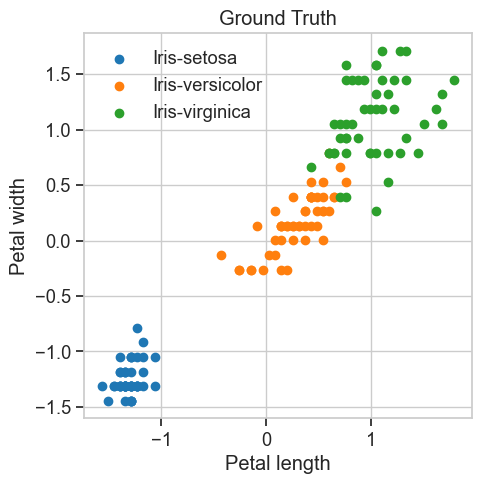

Name             KMeans
Iris-setosa      2         50
Iris-versicolor  0         48
                 1          2
Iris-virginica   0          4
                 1         46
dtype: int64

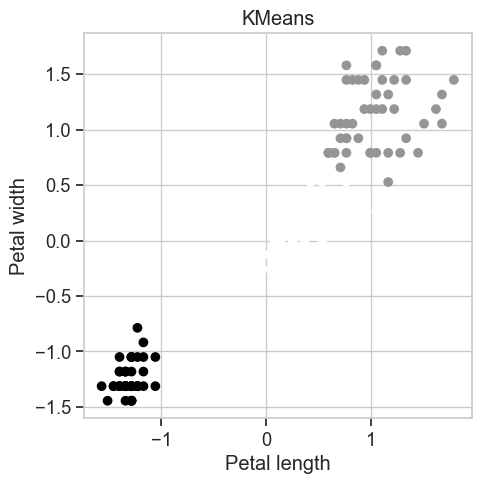

Name             DBSCAN
Iris-setosa      0         50
Iris-versicolor  1         50
Iris-virginica   1         50
dtype: int64

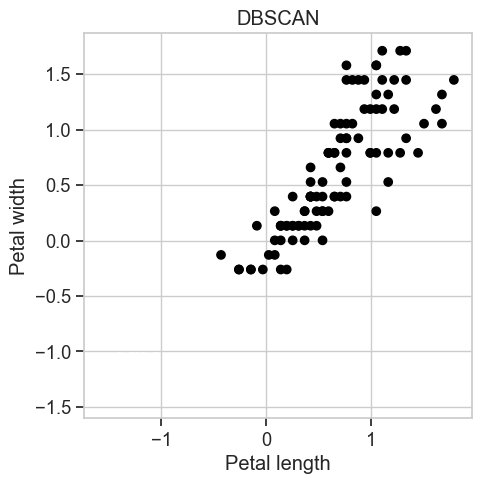

Name             single
Iris-setosa      1         50
Iris-versicolor  0         50
Iris-virginica   0         49
                 2          1
dtype: int64

Name             average
Iris-setosa      1          50
Iris-versicolor  0          49
                 2           1
Iris-virginica   0           2
                 2          48
dtype: int64

Name             complete
Iris-setosa      2           50
Iris-versicolor  0           25
                 1           25
Iris-virginica   0           50
dtype: int64

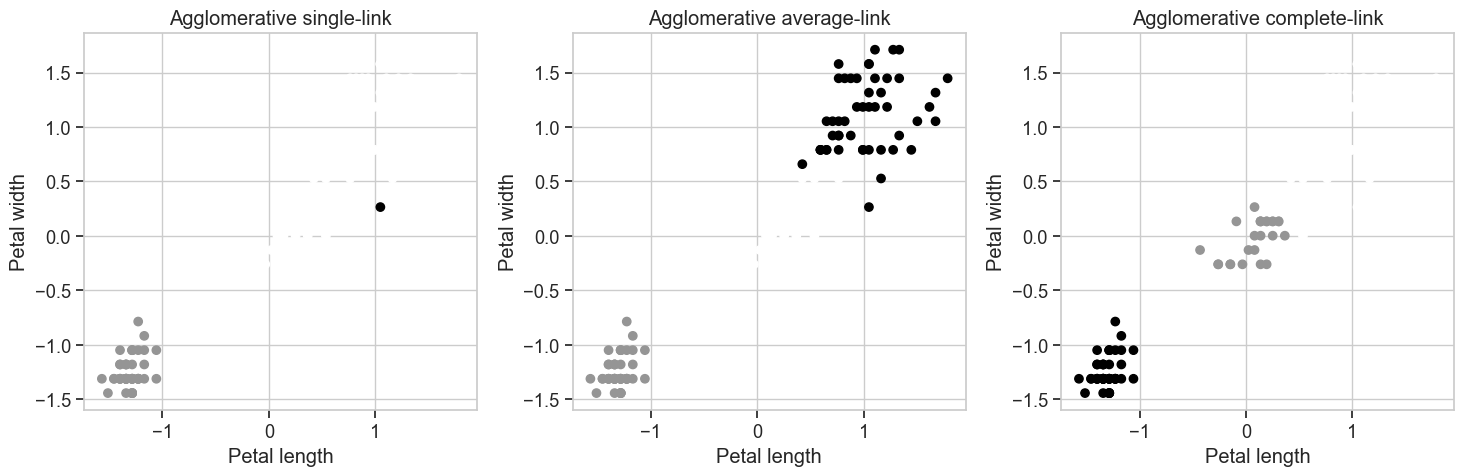

In [184]:
# import Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

# import DBSCAN
from sklearn.cluster import DBSCAN

# show frequency of each type of flower
display(iris.groupby('Name').size())

# plot the correct assignment
plt.figure(figsize=(5,5))

# create one series per type of flower
for name, group in iris.groupby('Name'):
    plt.scatter(group['PetalLength'], group['PetalWidth'], label=name)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("Ground Truth")
plt.legend()
plt.show()

# ***************************
# KMeans
# ***************************
estimator = KMeans(n_clusters = 3)
estimator.fit(iris[['PetalLength', 'PetalWidth']])

# show the frequency of each type of flower in every cluster
display(iris.join(pd.Series(estimator.labels_, name="KMeans")).groupby(['Name', 'KMeans']).size())

# plot the clusters
plt.figure(figsize=(5,5))
plt.title("KMeans")
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.scatter(iris['PetalLength'], iris['PetalWidth'], c=estimator.labels_)
plt.show()


# ***************************
# DBSCAN
# ***************************
estimator = DBSCAN()
estimator.fit(iris[['PetalLength', 'PetalWidth']])
# show the frequency of each type of flower in every cluster
display(iris.join(pd.Series(estimator.labels_, name="DBSCAN")).groupby(['Name', 'DBSCAN']).size())

# plot the clusters
plt.figure(figsize=(5,5))
plt.scatter(iris['PetalLength'], iris['PetalWidth'], c=estimator.labels_)
plt.title("DBSCAN")
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()


# ***************************
# Agglomerative
# ***************************
plt.figure(1, (15,5))
for i, mode in enumerate(['single', 'average', 'complete']):
    estimator = AgglomerativeClustering(n_clusters = 3, linkage=mode)
    estimator.fit(iris[['PetalLength', 'PetalWidth']])
    
    # show the frequency of each type of flower in every cluster
    display(iris.join(pd.Series(estimator.labels_, name=mode)).groupby(['Name', mode]).size())
    
    # plot the clusters
    plt.subplot(1,3,i+1)
    plt.tight_layout()
    plt.title("Agglomerative {}-link".format(mode))
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.scatter(iris['PetalLength'], iris['PetalWidth'], c=estimator.labels_)
plt.show()

Agglomerative clustering with single link works best here.

## H3. Clustering the Geo Data Set

### H3.1. The geo data set contains the coordinates (x & y) of housings in a certain area. Have a look at the data and visualize it with a scatter plot, using the ```area``` feature as colour.

In [185]:
# read the dataset into a dataframe
geo_data = pd.read_excel('data\geo.xlsx')

# show the first few lines
geo_data.head()

,id,x,y,area
0,1,1,1,1
1,2,2,1,1
2,3,3,1,1
3,4,4,1,1
4,5,5,1,1


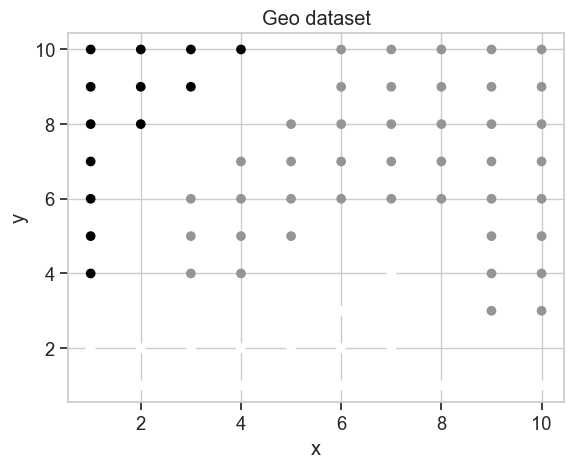

In [186]:
# create a scatter plot
plt.title("Geo dataset")
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(geo_data['x'], geo_data['y'], c=geo_data['area'])
plt.show()

### H3.2. Cluster the data using k-Means (k=3). Do the clusters represent the original areas?
We cluster the dataset and plot again, this time using the cluster ids as colour.

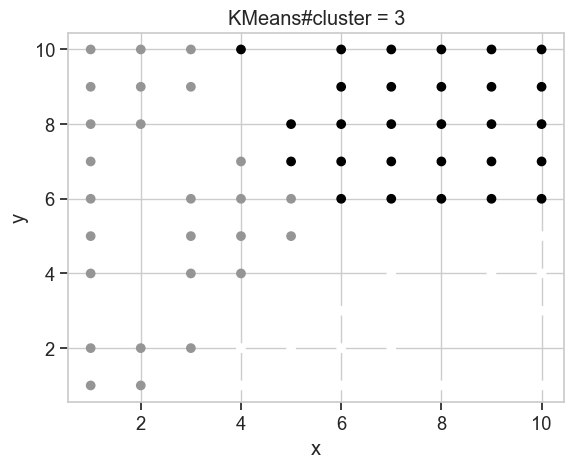

In [187]:
# create the clustering
estimator = KMeans(n_clusters = 3)
cluster_ids = estimator.fit_predict(geo_data[['x', 'y']])

# plot again
plt.title("KMeans#cluster = 3")
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(geo_data['x'], geo_data['y'], c=cluster_ids)
plt.show()

**Solution:** Although its clearly recognizable that there are 3 different areas described by the geo data set, k-Means is not able to reproduce these areas as they have no representative centroid (are not of globular shaped), which leads to miss-clustered items.

### H3.3. Apply DBSCAN and play around with the epsilon. Can you reproduce the original areas using this cluster algorithm?

We run DBSCAN in its default configuration first.
Then, we systematically test different parameter settings for ```min_samples``` and ```eps```.

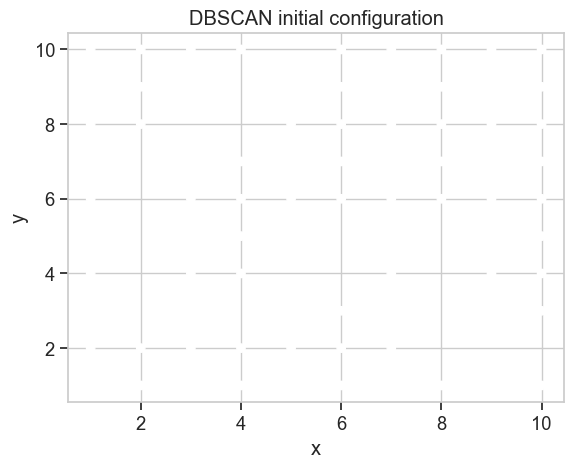

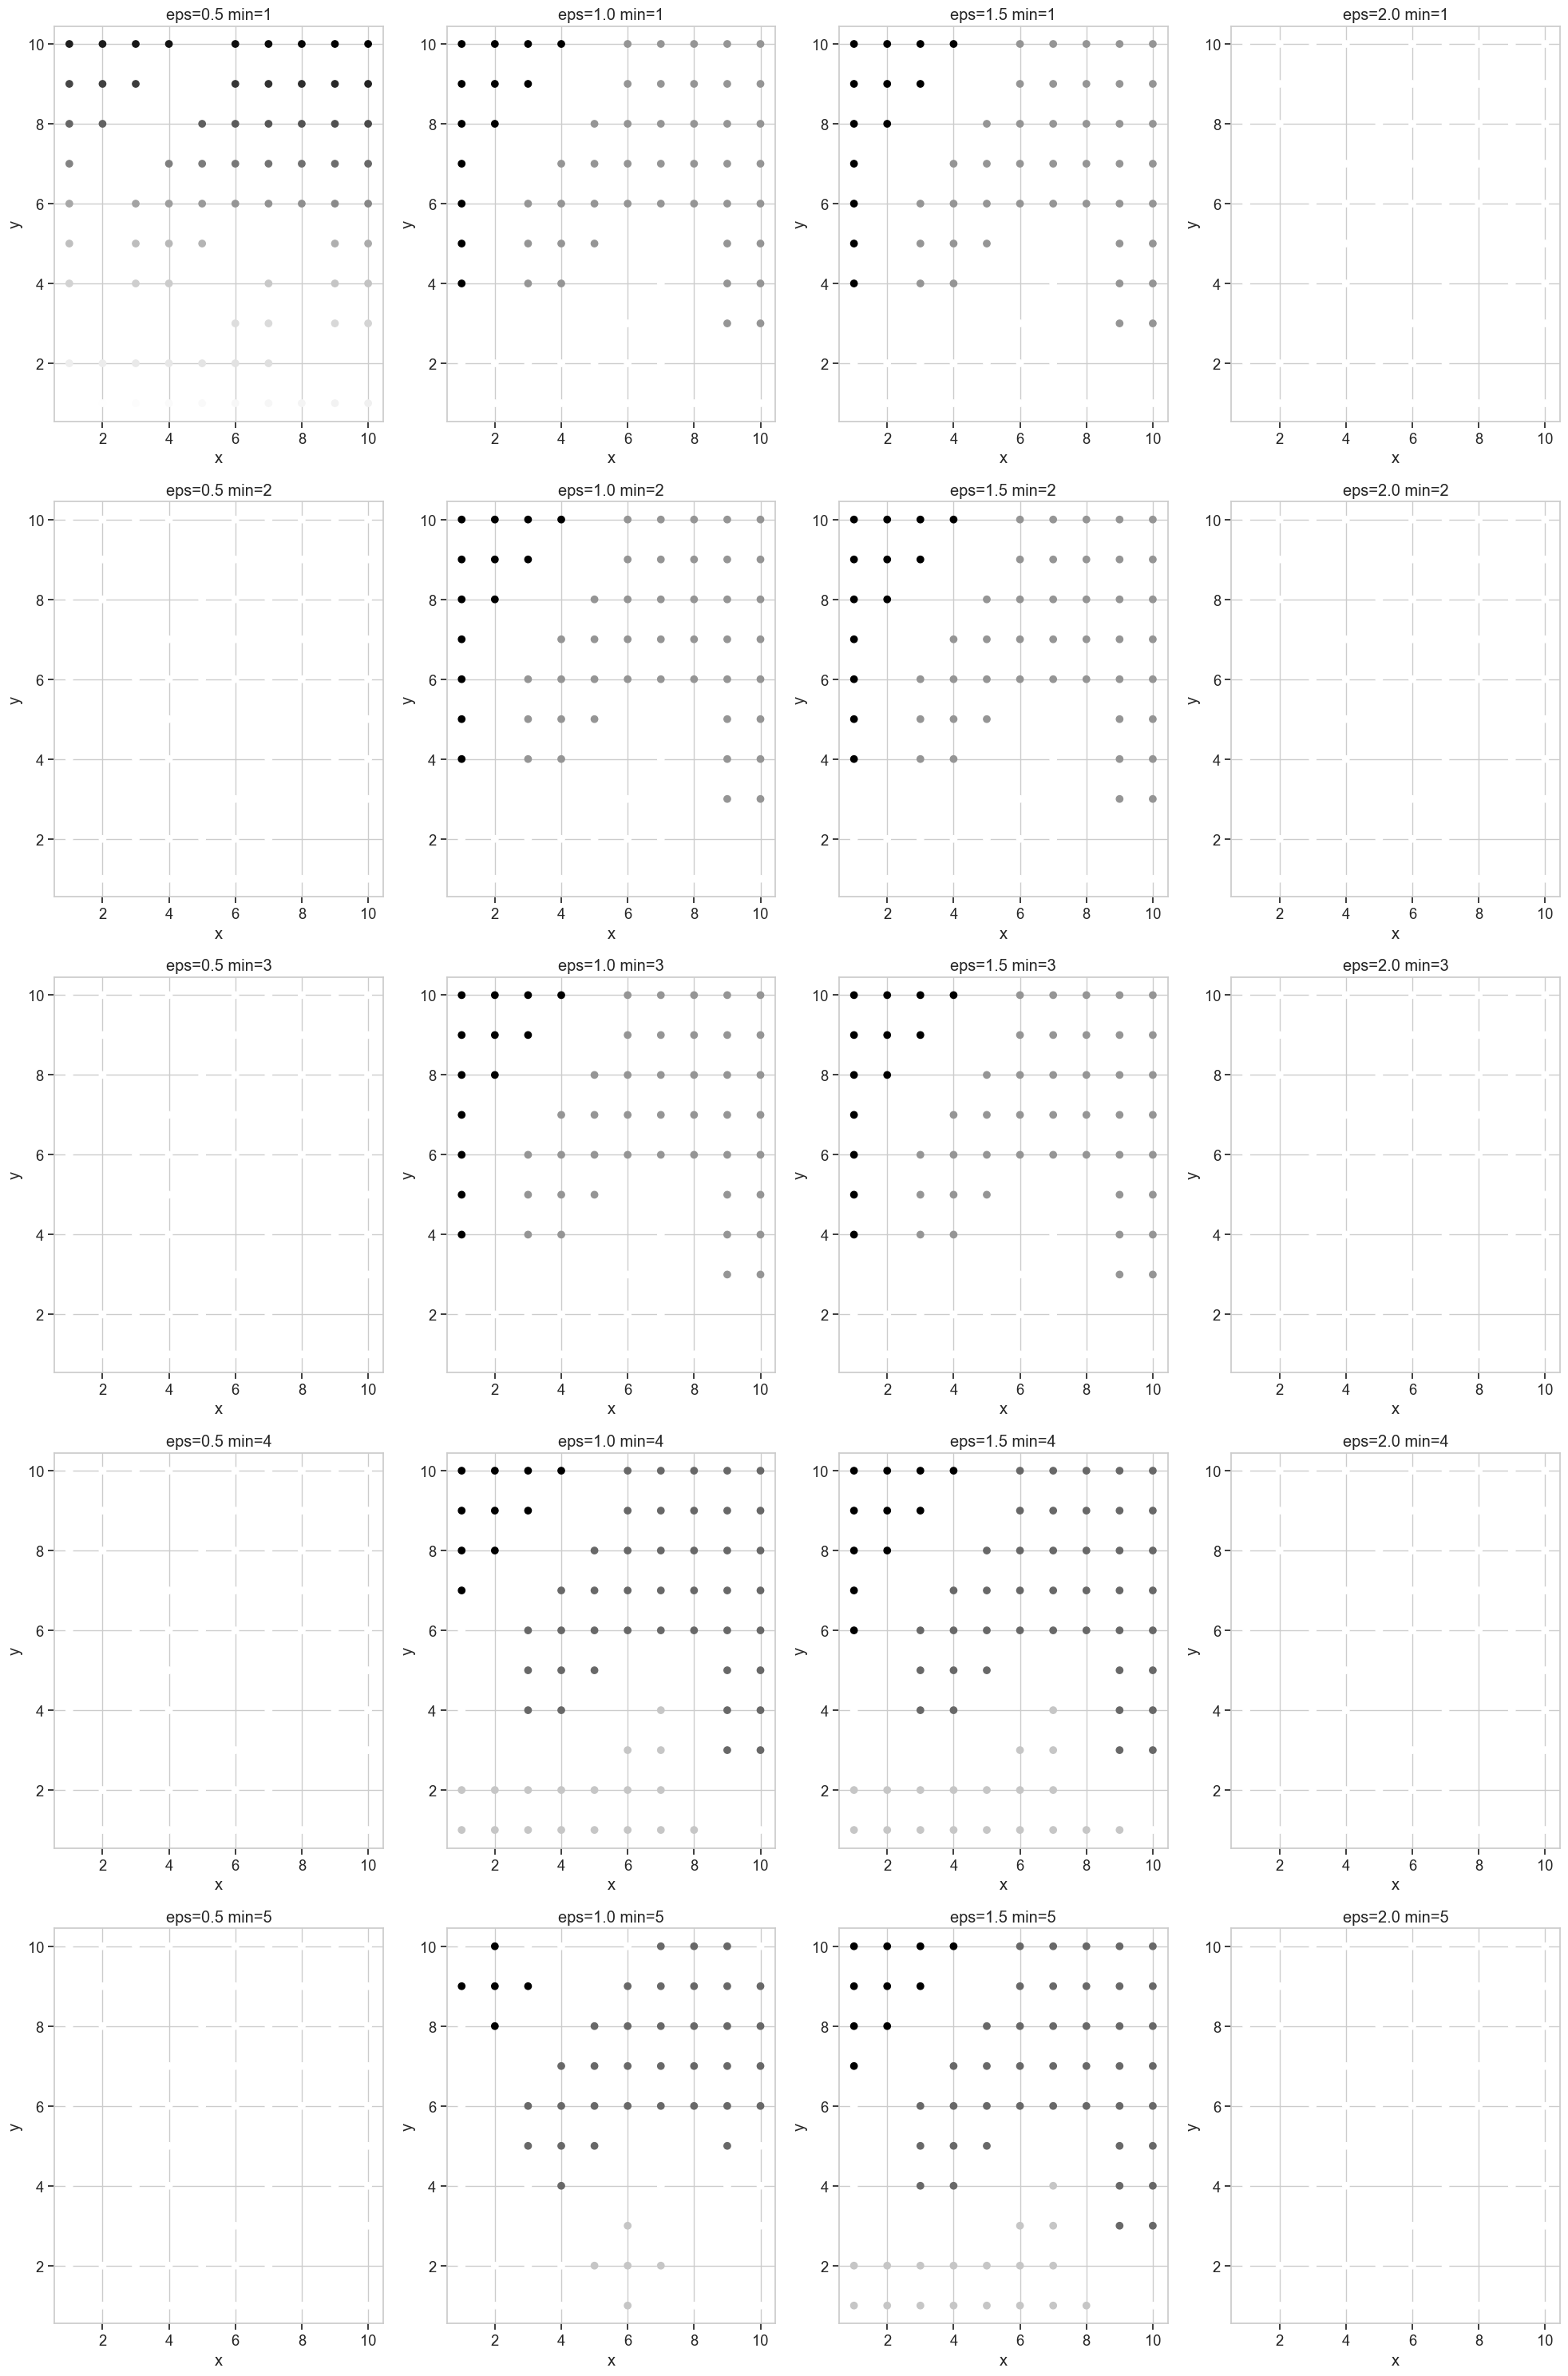

In [188]:
# show the result of running DBSCAN with default configuration
cluster_ids = DBSCAN().fit_predict(geo_data[['x', 'y']])
plt.scatter(geo_data['x'], geo_data['y'], c=cluster_ids)
plt.title("DBSCAN initial configuration")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# test different parameter settings and plot the results
plt.figure(1, (20,30))
counter = 1
for min_samples in [1,2,3,4,5]:
    for eps in [0.5, 1.0, 1.5, 2.0]:
        cluster_ids = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(geo_data[['x', 'y']])
        
        plt.subplot(5,4,counter)
        plt.tight_layout()
        plt.scatter(geo_data['x'], geo_data['y'], c=cluster_ids)
        plt.title("eps={} min={}".format(eps, min_samples))
        plt.xlabel('x')
        plt.ylabel('y')
        
        counter += 1
plt.show()

**Solution:**
Applying DBScan to the data-set does not work using the default set-up (eps=0.5, min_samples=5), as the data set only has integer coordinates (minimum distance 1).
With epsilon between set to 1.0 or 1.5 as weel as minimum points between 1 and 3 lets DBScan reproduce the original areas.

## H4. Clustering the Zoo Data Set
### H4.1. The Zoo data set describes 101 animals using 18 different attributes. The data set is provided in ILIAS as an ARFF file. Load this dataset.

In [189]:
# import arff
from scipy.io import arff

# load the file and create a dataframe
zoo_arff_data, zoo_arff_meta = arff.loadarff('data\zoo.arff')
zoo_data = pd.DataFrame(zoo_arff_data)

# solve the encoding issue in the data
columns_with_binary_strings = zoo_data.select_dtypes('object').columns.values
zoo_data[columns_with_binary_strings] = zoo_data[columns_with_binary_strings].apply(lambda x: x.str.decode("utf-8"))

zoo_data.head()

,animal,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,true,false,false,true,false,false,true,true,true,true,false,false,4.0,false,false,true,mammal
1,antelope,true,false,false,true,false,false,false,true,true,true,false,false,4.0,true,false,true,mammal
2,bass,false,false,true,false,false,true,true,true,true,false,false,true,0.0,true,false,false,fish
3,bear,true,false,false,true,false,false,true,true,true,true,false,false,4.0,false,false,true,mammal
4,boar,true,false,false,true,false,false,true,true,true,true,false,false,4.0,true,false,true,mammal


### H4.2. Cluster the data set using Agglomerative Hierarchical Clustering. Experiment with different parameter settings in order to generate a nice species tree.

We first have to encode the non-numerical features. Note that the ```type``` feature already contains a classification of the species, so we exclude it and use it to see if our results make sense.

In [190]:
#encode parameters:
from sklearn import preprocessing
selected_attributes = ['hair','feathers', 'milk', 'airborne', 'toothed', 
                       'backbone', 'breathes', 'venomous', 'fins', 'tail', 
                       'domestic', 'catsize']

ordinal_encoder = preprocessing.OrdinalEncoder()
zoo_data[selected_attributes] = ordinal_encoder.fit_transform(zoo_data[selected_attributes])
zoo_data.head()

,animal,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1.0,0.0,false,1.0,0.0,false,true,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,mammal
1,antelope,1.0,0.0,false,1.0,0.0,false,false,1.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0,mammal
2,bass,0.0,0.0,true,0.0,0.0,true,true,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,fish
3,bear,1.0,0.0,false,1.0,0.0,false,true,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,mammal
4,boar,1.0,0.0,false,1.0,0.0,false,true,1.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0,mammal


Then we can create a clustering and look at the dendrogram.
As some of the animals have very similar features, they have a distance of 0, which means there will be lines in the dendrogram at ```x==0```.
In the default configuration, however, we cannot see these lines. 
To solve this, we need to move the left limit of the figure further to the left using the [```set_xlim()``` function](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_xlim.html).

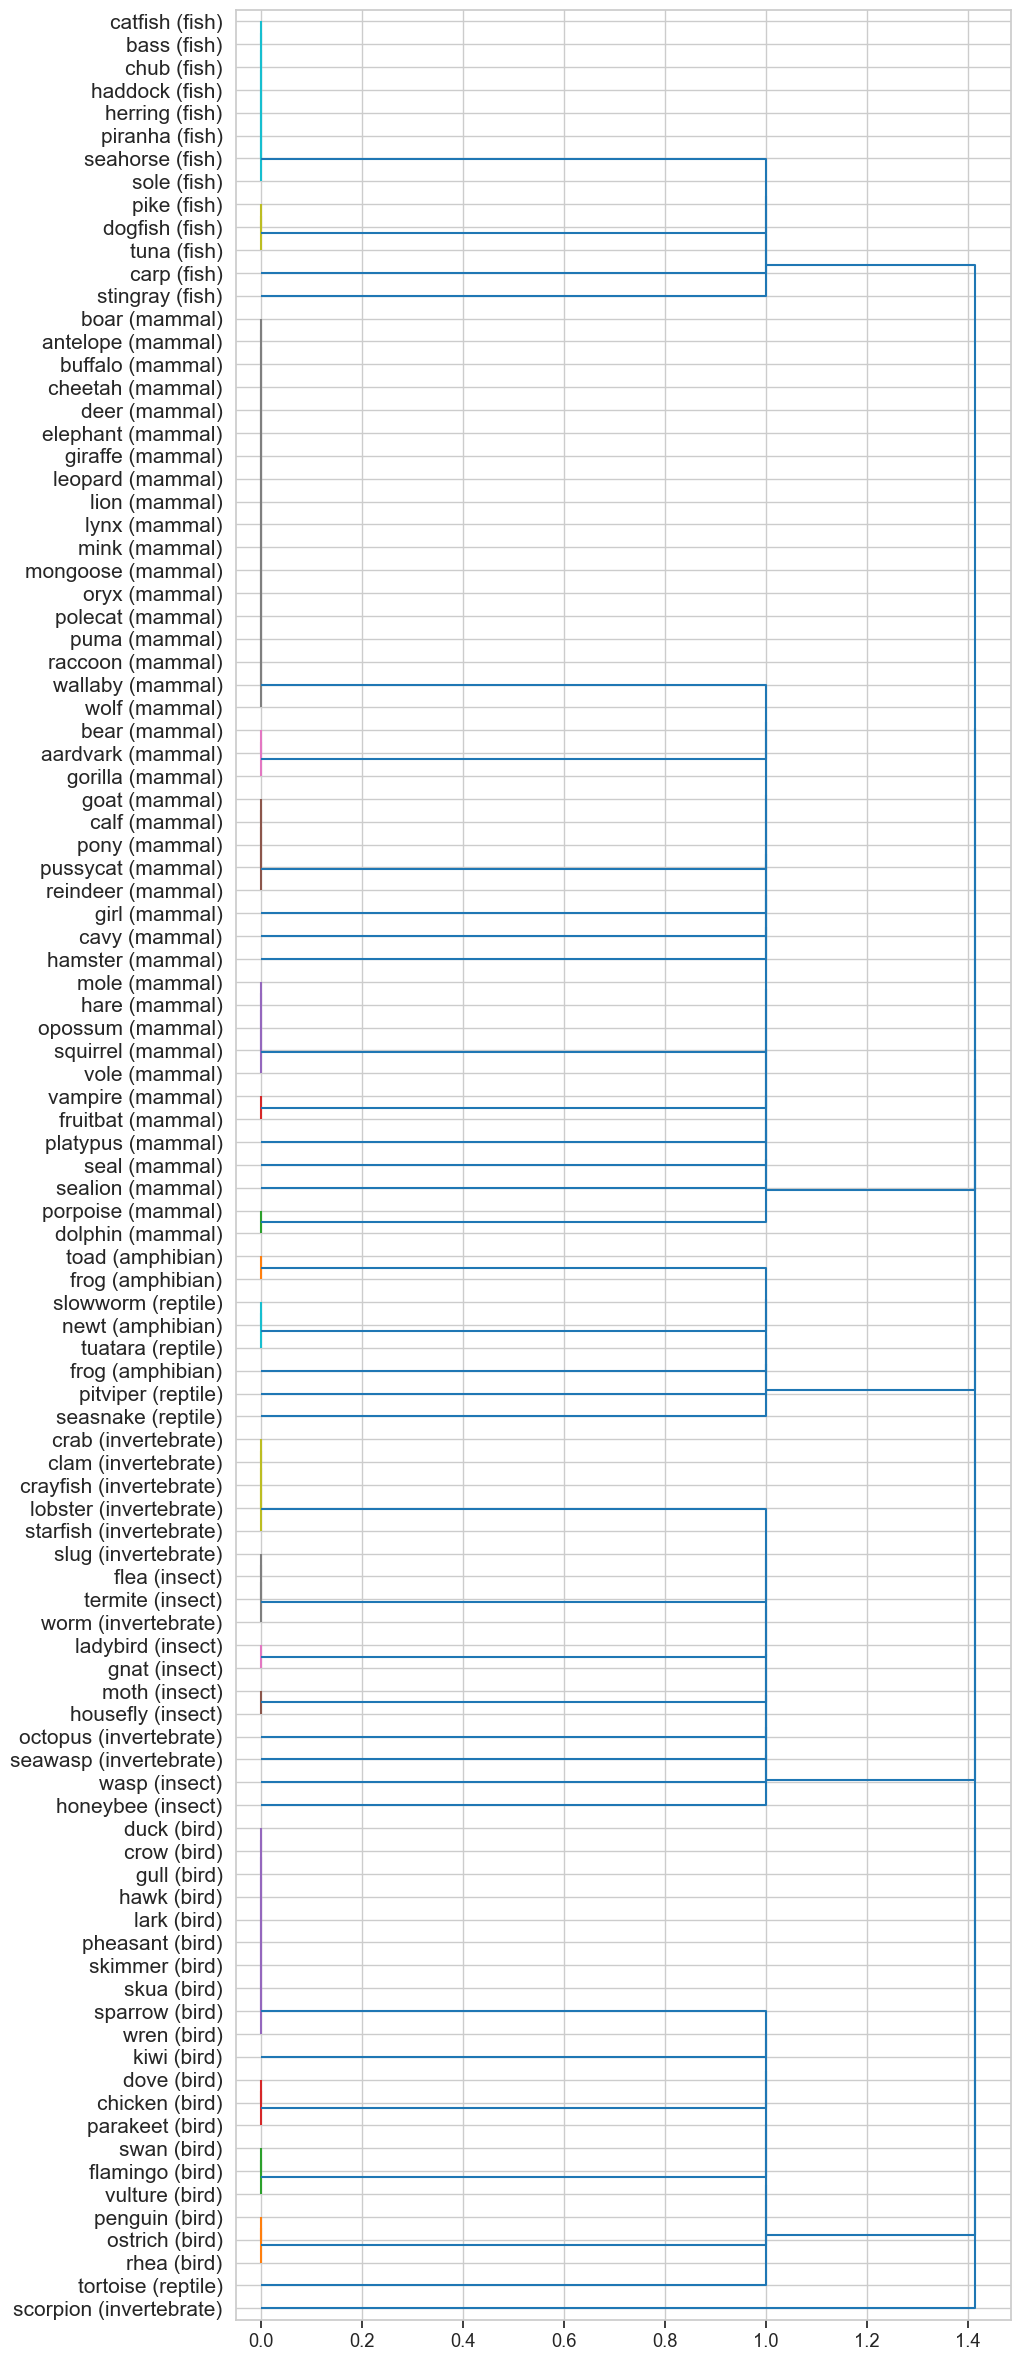

In [191]:
fig = plt.figure(figsize=(10, 30))

ax = dendrogram(
    linkage(zoo_data[selected_attributes], method='single'),
    orientation='right',
    labels=list(zoo_data['animal'].values + " (" + zoo_data['type'].values + ")"),
    leaf_font_size = 15
)

# get the axes of the current figure (not the plot!)
axes = plt.gca()
# set the left limit further to the left, so we can see the lines drawn at x=0
axes.set_xlim((-0.05, axes.get_xlim()[1]))


plt.show()

## H5. Evaluation of anomaly detection

In this task we work with a data set about breast cancer. It contains various features from cancer diagnostics. The majority of the data set is obtained from non-cancer patients (label 'B'), and 20 examples are obtained from patients where a cancer is present (label 'M'). Because of their low frequency, the cancer examples can be treated as outliers and we can use the previously mentioned techniques to detect them.

- Apply the techniques learned in the previous task to this data set.
- Use a ROC-curve to visualise the performance of every technique (outliers should be treated as the 'true' class).

In [192]:
df = pd.read_csv(r'data\breast_cancer_outliers.csv', sep=';').drop(columns='id')
X, y = df.drop(columns='class'), df['class']

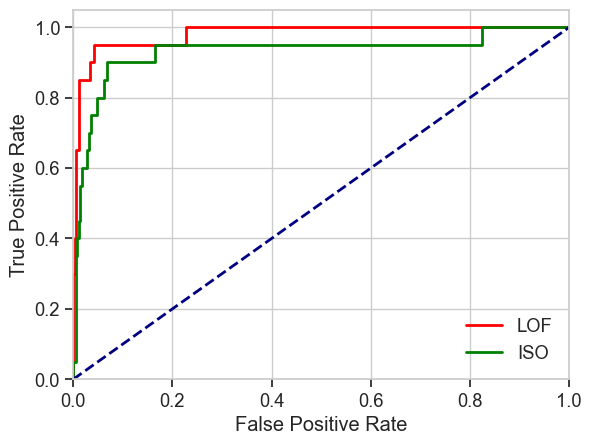

In [193]:
# Apply the anomaly detection techniques and draw a ROC-curve of their performance.
# How to work with ROC-curves in scikit-learn: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

# --- SOLUTION ---
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelBinarizer

y_actual = LabelBinarizer().fit_transform(y)
estimates = []

# LOF
lof_score = LocalOutlierFactor().fit(X).negative_outlier_factor_ * -1
estimates.append({'name': 'LOF', 'score': lof_score, 'color': 'Red'})

# IsoForest
iso_score = IsolationForest().fit(X).score_samples(X) * -1
estimates.append({'name': 'ISO', 'score': iso_score, 'color': 'Green'})

plt.figure()
for e in estimates:
    fpr, tpr, _ = roc_curve(y_actual, e['score'])
    plt.plot(fpr, tpr, color=e['color'], lw=2, label=e['name'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


Conclusion: LOF performs very well. ISO performs a little bit worse but still reasonably good.

## H6. Anomaly detection for preprocessing

We want to use anomaly detection to ignore outliers during training of a classifier in order to improve its performance. We use an alternative version of the Iris data set where some errors happened during data entry. After learning a simple classifier for the task, we try to improve it by removing outliers (to simplify the task, outliers are marked in the training set).

- Train a decision tree classifier on the training set and evaluate its performance on the test set
- Try to improve the performance by removing outliers during the _training phase_

In [194]:
df_train = pd.read_csv('data\iris_shuffled_train.csv', sep=';').drop(columns='id')
X_train, y_train = df_train.drop(columns=['label', 'is_outlier']), df_train['label']
df_test = pd.read_csv('data\iris_shuffled_test.csv', sep=';').drop(columns='id')
X_test, y_test = df_test.drop(columns='label'), df_test['label']

In [195]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# Complete this function which trains a decision tree on the training set and evaluates it on the test set

def evaluate_decision_tree(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):
    # --- SOLUTION ---
    y_pred = DecisionTreeClassifier(random_state=42).fit(X_train, y_train).predict(X_test)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    print(f'Performance-Scores: P={precision:.2f} R={recall:.2f} F1={f1:.2f}')

evaluate_decision_tree(X_train, y_train, X_test, y_test)

Performance-Scores: P=0.62 R=0.62 F1=0.62


In [196]:
# Now change df_train by removing outliers with the techniques given in the previous tasks. Does this improve the results?

# --- SOLUTION ---
from numpy import linspace
for contamination in linspace(.1, .5, 5):
    print()
    print(f'=== CONTAMINATION {contamination:.1f} ===')
    
    print('--- LOF ---')
    outlier_mask_LOF = LocalOutlierFactor(contamination=contamination).fit_predict(X_train) == 1
    evaluate_decision_tree(X_train[outlier_mask_LOF], y_train[outlier_mask_LOF], X_test, y_test)
    
    print('--- ISO ---')
    outlier_mask_ISO = IsolationForest(contamination=contamination).fit_predict(X_train) == 1
    evaluate_decision_tree(X_train[outlier_mask_ISO], y_train[outlier_mask_ISO], X_test, y_test)


=== CONTAMINATION 0.1 ===
--- LOF ---
Performance-Scores: P=0.71 R=0.71 F1=0.71
--- ISO ---
Performance-Scores: P=0.62 R=0.62 F1=0.62

=== CONTAMINATION 0.2 ===
--- LOF ---
Performance-Scores: P=0.71 R=0.71 F1=0.71
--- ISO ---
Performance-Scores: P=0.84 R=0.84 F1=0.84

=== CONTAMINATION 0.3 ===
--- LOF ---
Performance-Scores: P=1.00 R=1.00 F1=1.00
--- ISO ---
Performance-Scores: P=1.00 R=1.00 F1=1.00

=== CONTAMINATION 0.4 ===
--- LOF ---
Performance-Scores: P=0.98 R=0.98 F1=0.98
--- ISO ---
Performance-Scores: P=0.98 R=0.98 F1=0.98

=== CONTAMINATION 0.5 ===
--- LOF ---
Performance-Scores: P=0.98 R=0.98 F1=0.98
--- ISO ---
Performance-Scores: P=0.98 R=0.98 F1=0.98


Conclusion: Removal of outliers can improve the classification performance.